In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

model_name = '20221007_btc_one_nn'

In [2]:
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP'] # binance, bybit

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2022-07-08 21:00:00+00:00,ADAUSDT,0.4701,0.4731,0.4671,0.4674,23271114.0,1.095514e+07,19177.0,11731510.0,...,0.470872,0.470775,0.001503,0.000543,0.471177,0.470570,0.000258,-0.000348,0.001289,0.000002
1,2022-07-20 19:00:00+00:00,ADAUSDT,0.5089,0.5128,0.5032,0.5052,34962395.0,1.774341e+07,30250.0,17279381.0,...,0.507722,0.507642,0.002051,0.000584,0.508148,0.507293,0.000373,-0.000482,0.001684,0.000003
2,2022-07-24 12:00:00+00:00,ADAUSDT,0.5262,0.5305,0.5223,0.5237,52979601.0,2.788418e+07,41357.0,25678072.0,...,0.526623,0.526425,0.001789,0.000774,0.527147,0.526110,0.000488,-0.000548,0.001969,0.000005
3,2022-07-27 00:00:00+00:00,ADAUSDT,0.4674,0.4687,0.4634,0.4652,31111279.0,1.448926e+07,24080.0,13589855.0,...,0.465348,0.465267,0.001267,0.000596,0.465782,0.464945,0.000402,-0.000435,0.001797,0.000004
4,2022-07-15 20:00:00+00:00,ADAUSDT,0.4475,0.4537,0.4432,0.4453,54673926.0,2.448470e+07,42036.0,28570664.0,...,0.446385,0.446367,0.001678,0.000854,0.446965,0.445958,0.000555,-0.000452,0.002252,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241815,2021-11-17 07:00:00+00:00,MATICUSDT,1.5215,1.5489,1.5073,1.5328,7928678.0,1.212844e+07,21684.0,3830067.0,...,1.524733,1.524658,0.012387,0.002233,1.526488,1.523025,0.001885,-0.001578,0.002269,0.000006
241816,2021-11-15 09:00:00+00:00,MATICUSDT,1.7442,1.7690,1.7386,1.7578,12044402.0,2.114491e+07,36394.0,5680896.0,...,1.754850,1.755817,0.007133,0.002226,1.756210,1.753075,0.001610,-0.001525,0.001786,0.000004
241817,2021-10-31 03:00:00+00:00,MATICUSDT,1.9113,1.9494,1.8949,1.9487,9549132.0,1.833721e+07,52414.0,4815594.0,...,1.914738,1.915192,0.013883,0.003910,1.917207,1.911813,0.003145,-0.002248,0.002813,0.000010
241818,2021-11-03 00:00:00+00:00,MATICUSDT,1.9416,1.9927,1.9399,1.9734,19082415.0,3.749070e+07,69466.0,9379611.0,...,1.959675,1.961183,0.015315,0.003893,1.962325,1.956372,0.003192,-0.002762,0.003036,0.000010


op          hi         lo  \
timestamp                 symbol                                      
2013-10-06 21:00:00+00:00 BTC      122.00000   122.00000   122.0000   
2013-10-07 20:00:00+00:00 BTC      123.61000   123.61000   123.6100   
2013-10-08 02:00:00+00:00 BTC      123.91000   123.91000   123.9000   
2013-10-08 05:00:00+00:00 BTC      124.19000   124.19000   124.1800   
2013-10-09 09:00:00+00:00 BTC      124.01687   124.01687   123.8400   
...                                      ...         ...        ...   
2022-11-22 22:00:00+00:00 ETH     1130.44000  1140.00000  1125.3700   
                          LINK       6.34900     6.38700     6.2970   
                          LTC       69.08000    70.58000    69.0800   
                          MATIC      0.83990     0.85500     0.8383   
                          XRP        0.37670     0.37840     0.3754   

                                         cl        volume      twap_5m  \
timestamp                 symbol                                         
2013-10-06 21:00:00+00:00 BTC      122.0000  1.000000e-01   122.000000   
2013-10-07 20:00:00+00:00 BTC      123.6100  1.000000e-01   123.610000   
2013-10-08 02:00:00+00:00 BTC      123.9000  1.991600e+00   123.900000   
2013-10-08 05:00:00+00:00 BTC      124.1800  2.000000e+00   124.180000   
2013-10-09 09:00:00+00:00 BTC      123.8400  2.823000e+00   123.840000   
...                                     ...           ...          ...   
2022-11-22 22:00:00+00:00 ETH     1137.0000  1.432570e+05  1130.668333   
                          LINK       6.3530  2.638726e+06     6.336667   
                          LTC       69.6900  5.037114e+05    69.469167   
                          MATIC      0.8476  2.497548e+07     0.843900   
                          XRP        0.3778  3.694761e+07     0.376608   

                                  extended  
timestamp                 symbol            
2013-10-06 21:00:00+00:00 BTC         True  
2013-10-07 20:00:00+00:00 BTC         True  
2013-10-08 02:00:00+00:00 BTC         True  
2013-10-08 05:00:00+00:00 BTC         True  
2013-10-09 09:00:00+00:00 BTC         True  
...                                    ...  
2022-11-22 22:00:00+00:00 ETH        False  
                          LINK       False  
                          LTC        False  
                          MATIC      False  
                          XRP        False  

[421155 rows x 7 columns]

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    for t_center in [6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [6 * 4, 12 * 4, 24 * 4, 36 * 4, 48 * 4, 72 * 4, 96 * 4]:
    # for t_center in [3, 6, 8, 12, 18, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16]:
    # for t in [2, 4, 8, 16, 32, 64]:
        dfs2 = []
        t_shifts = [0]
        # t_shifts = [-1, 0, 1]
        for t_shift in t_shifts:
            t = t_center + t_shift
            
            feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
            feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
            feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

            feature_stoch_k, feature_stoch_d = stoch(t)
            feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
            feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

            feature_stochf_k, feature_stochf_d = stochf(t)
            feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
            feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

            feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
            feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
            feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

            feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))

            ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

            dfs2 += [
                adx(t).rename('feature_adx_{}'.format(t)),
                adxr(t).rename('feature_adxr_{}'.format(t)),
                feature_rsi,
                rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
                rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
                aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
                aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
                aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
                # cci(t).rename('feature_cci_{}'.format(t)),
                # cmo(t).rename('feature_cmo_{}'.format(t)),
                dx(t).rename('feature_dx_{}'.format(t)),
                mfi(t).rename('feature_mfi_{}'.format(t)),
                # trix(t).rename('feature_trix_{}'.format(t)),
                # feature_integ_std,
                # feature_std,
                # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
                # feature_mom,
                # atr(t).rename('feature_atr_{}'.format(t)),
                # natr(t).rename('feature_natr_{}'.format(t)),
                range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
                # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
                # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
                # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
                volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
                range_pos(t).rename('feature_range_pos_{}'.format(t)),
                range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
                # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
                obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
                ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
                # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
                # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
                feature_stoch_k,
                feature_stoch_d,
                (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
                (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
                feature_stochf_k,
                feature_stochf_d,
                (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
                (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
                feature_stochrsi_k,
                feature_stochrsi_d,
                (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
                (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
                ultosc(t).rename('feature_ultosc_{}'.format(t)),
                volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
                skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
                # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
                (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
                feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
                (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
                # dimension less but not bounded
                # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
                # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
                # zscore(t).rename('feature_zscore_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
                # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
                # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
            ]
            
        feature_count = len(dfs2) // len(t_shifts)
        for j in range(feature_count):
            for i in range(1, len(t_shifts)):
                dfs2[j] += dfs2[j + feature_count * i]
            dfs2[j] /= len(t_shifts)
        dfs += dfs2[:feature_count]

    return pd.concat(dfs, axis=1)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
import lightgbm as lgb
import numpy as np
import pandas as pd

class NonstationaryFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, remove_count=None, remove_ratio=None):
        if remove_count and remove_ratio:
            raise Exception('remove_count and remove_ratio cannot be set simultaneously')
        self.estimator = lgb.LGBMRegressor(n_jobs=-1, random_state=1) if estimator is None else estimator
        self.remove_count = remove_count
        self.remove_ratio = remove_ratio

    def fit(self, X, y=None):
        X = self._validate_data(X)

        model = clone(self.estimator)

        model.fit(X, np.arange(X.shape[0]))
        importances = model.feature_importances_

        if self.remove_count:
            remove_count = self.remove_count
        else:
            remove_count = int(self.remove_ratio * X.shape[1])

        features = list(range(X.shape[1]))
        feature_imp = pd.DataFrame(zip(importances, features), columns=['value', 'feature'])
        feature_imp = feature_imp.sort_values('value')

        for i in range(X.shape[1] - remove_count, X.shape[1]):
            features.remove(int(feature_imp['feature'].iloc[i]))

        self.selected_features_ = np.array(features)

        return self

    def transform(self, X, y=None):
        X = self._validate_data(X)

        return X[:, self.selected_features_].copy()

    def inverse_transform(self, X, y=None):
        raise Exception('inverse_transform not implemented')


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

2022-11-22 23:07:06.869216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 23:07:07.028564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 23:07:07.028616: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-22 23:07:07.059450: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 23:07:07.881575: W tensorflow/stream_executor/platform/de

In [6]:
# https://github.com/CyberZHG/keras-drop-connect/blob/master/LICENSE

from inspect import getfullargspec

class GaussianDropConnect(tf.keras.layers.Wrapper):
    def __init__(self, layer, rate=0.0, seed=None, **kwargs):
        super(GaussianDropConnect, self).__init__(layer, **kwargs)
        if isinstance(rate, dict):
            for name in list(rate.keys()):
                rate[name] = min(1., max(0., rate[name]))
        else:
            rate = min(1., max(0., rate))
        self.rate = rate
        self.seed = seed
        self.supports_masking = self.layer.supports_masking

    def build(self, input_shape=None):
        if not self.layer.built:
            self.layer.build(input_shape)
        super(GaussianDropConnect, self).build()
        
        def dropped_weight(weight, drop_connect_rate):
            sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
            def _dropped_weight():
                return weight * tf.keras.backend.random_normal(
                    shape=tf.shape(weight),
                    mean=1.0,
                    stddev=sigma,
                    dtype=weight.dtype,
                    seed=self.seed
                )
                return dropped
            return _dropped_weight

        training = None
        
        weights = []
        for w in self.layer.trainable_weights:
            weights.append(tf.keras.backend.in_train_phase(dropped_weight(w, self.rate), w, training=training))
        self.layer.trainable_weights = weights
        
    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def compute_mask(self, inputs, mask=None):
        return self.layer.compute_mask(inputs, mask)

    def call(self, inputs, training=None, mask=None):
        def has_arg(fn, name):
            arg_spec = getfullargspec(fn)
            return name in arg_spec.args or name in arg_spec.kwonlyargs

        kwargs = {}
        if has_arg(self.layer.call, 'training'):
            kwargs['training'] = training
        if has_arg(self.layer.call, 'mask'):
            kwargs['mask'] = mask

#         def dropped_weight(weight, drop_connect_rate):
#             sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
#             def _dropped_weight():
#                 return weight * tf.keras.backend.random_normal(
#                     shape=tf.shape(weight),
#                     mean=1.0,
#                     stddev=sigma,
#                     dtype=weight.dtype,
#                     seed=self.seed
#                 )
#                 return dropped
#             return _dropped_weight

#         origins = self.layer.trainable_weights
        
#         # origins = {}
#         if isinstance(self.rate, dict):
#             for name, rate in self.rate.items():
#                 w = getattr(self.layer, name)
#                 if w in self.layer.trainable_weights:
#                     origins[name] = w
#                     if 0. < rate < 1.:
#                         setattr(self.layer, name, )
#         else:
#             weights = []
#             for w in self.layer.trainable_weights:
#                 weights.append(tf.keras.backend.in_train_phase(dropped_weight(w, self.rate), w, training=training))
#             self.layer.set_weights(weights)
                    
# #             for name in dir(self.layer):
# #                 try:
# #                     w = getattr(self.layer, name)
# #                 except Exception as e:
# #                     continue
                
# #                 if w in self.layer.trainable_weights:
# #                     origins[name] = w
# #                     if 0. < self.rate < 1.:
# #                         setattr(self.layer, name, tf.keras.backend.in_train_phase(dropped_weight(w, self.rate), w, training=training))
        outputs = self.layer.call(inputs, **kwargs)
        # for name, w in origins.items():
        #     setattr(self.layer, name, w)
        # self.layer.set_weights(origins)
        return outputs

    def get_config(self):
        config = {
            'rate': self.rate,
            'seed': self.seed,
        }
        base_config = super(GaussianDropConnect, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [7]:
from tensorflow.python.ops import gen_math_ops, nn_ops

class GaussianDropConnectDense(Dense):
    def build(self, input_shape):
        super().build(input_shape)
        
        self.kernel_initial = self.kernel.numpy()
        # print(self.kernel_initial)
        
#         self.kernel_old = self.kernel
#         self.bias_old = self.bias
        
        
        
#         self.kernel = self.kernel_old
#         self.bias = self.bias_old * tf.keras.backend.random_normal(
#             shape=tf.shape(self.bias_old),
#             mean=1.0,
#             stddev=sigma,
#             dtype=self.bias_old.dtype,
#             seed=None
#         )
    
    def call(self, inputs, training=None):     
        # dropout_rate = 0.3   
        dropout_rate = 0.5      
        # dropout_rate = 0.7
        sigma = np.sqrt(dropout_rate / (1.0 - dropout_rate))
        
        # kernel = self.kernel_initial + tf.keras.backend.dropout(self.kernel - self.kernel_initial, dropout_rate, seed=None) / (1.0 - dropout_rate)
        kernel = self.kernel_initial + (self.kernel - self.kernel_initial) * tf.keras.backend.random_normal(
            shape=tf.shape(self.kernel),
            mean=1.0,
            stddev=sigma,
            dtype=self.kernel.dtype,
            seed=None
        )
        bias = self.bias
        
        # kernel = self.kernel * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.kernel),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.kernel.dtype,
        #     seed=None
        # )
        # bias = self.bias * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.bias),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.bias.dtype,
        #     seed=None
        # )
        
        kernel = tf.keras.backend.in_train_phase(kernel, self.kernel, training=training)
        bias = tf.keras.backend.in_train_phase(bias, self.bias, training=training)
        
        if inputs.dtype.base_dtype != self._compute_dtype_object.base_dtype:
          inputs = math_ops.cast(inputs, dtype=self._compute_dtype_object)

        rank = inputs.shape.rank
        if rank == 2 or rank is None:
            outputs = gen_math_ops.MatMul(a=inputs, b=kernel)
        # Broadcast kernel to inputs.
        else:
          outputs = standard_ops.tensordot(inputs, kernel, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [kernel.shape[-1]]
            outputs.set_shape(output_shape)

        if self.use_bias:
          outputs = nn_ops.bias_add(outputs, bias)

        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs

In [8]:
class WeightLenCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.initial_weights = self.model.get_weights()
        self.initial_weights_norm = self._calc_dist(self.initial_weights)
        self.prev_weights = self.initial_weights
        self.weight_len = 0.0

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        weight_dist = self._calc_dist(self.initial_weights, weights)
        weight_dist2 = self._calc_dist(self.initial_weights, weights, True)
        logs['weight_dist'] = weight_dist
        # logs['weight_dist2'] = weight_dist2
        logs['weight_len'] = self.weight_len
        logs['weight_ndist'] = weight_dist / self.initial_weights_norm
        logs['weight_nlen'] = self.weight_len / self.initial_weights_norm

    def on_train_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        self.weight_len += self._calc_dist(self.prev_weights, weights)
        self.prev_weights = weights
        
    def _calc_dist(self, w1, w2=None, normalized=False):
        d = 0.0
        for i in range(len(w1)):
            x = w1[i]
            y = w1[i] if w2 is None else w2[i] 
            if normalized:
                x = x / (1e-37 + np.sum(x ** 2) ** 0.5)
                y = y / (1e-37 + np.sum(y ** 2) ** 0.5)
            if w2 is None:
                d += np.sum(x ** 2)
            else:
                d += np.sum((x - y) ** 2)
        return d ** 0.5

In [9]:
class WeightShuffleCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 20:
            return
        
        weights = self.model.get_weights()
        for i in range(0, len(weights)):
        # for i in range(len(weights) // 2, len(weights)):
            w = weights[i]
            if False:
            # if len(w.shape) == 1:
                w[:] = 0.0
            else:
                # flatten shuffle
                w = np.random.permutation(w.flatten()).reshape(w.shape)
                # axis 0 shuffle
                # w = np.random.permutation(w)
                # axis 1 shuffle 
                # maybe overfit
                # if len(w.shape) == 2:
                #     w = np.random.permutation(w.T).T
                # else:
                #     w = np.random.permutation(w)
            weights[i] = w

        self.model.set_weights(weights)


In [10]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [11]:
# https://arxiv.org/pdf/2002.08253.pdf
class MarsConstraint(tf.keras.constraints.Constraint):
    def __init__(self, gamma):
        self.gamma = gamma
        self.initial_weight = None

    def __call__(self, w):
        w = w - self.initial_weight
        norms = tf.keras.backend.sum(tf.keras.backend.abs(w), axis=range(len(w.shape) - 1), keepdims=True)
        w *= (1.0 / tf.keras.backend.maximum(1.0, norms / self.gamma))
        w += self.initial_weight
        return w

    def get_config(self):
        return { "gamma": self.gamma }

In [12]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [13]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [14]:

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self, ensemble=10):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        # self._model = lgb.LGBMRegressor(
        #     n_estimators=1000,
        #     learning_rate=0.01,
        #     extra_trees=True,
        #     # colsample_bytree=0.9,
        #     colsample_bytree=0.03,
        #     # lambda_l2=1e1,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.provider_configs = provider_configs
        self.merge_data = merge_data
        
        self.ensemble = ensemble

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            # verbose=0,
            # mode="auto",
            # min_delta=0.0001,
            # cooldown=0,
            # min_lr=0,
        )
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            patience=10,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )

        # lr1 = 0.002
        lr1 = 0.002 * 1e-1
        lr0 = lr1 * 1e-2
        def scheduler(epoch, lr):
            if epoch <= 10:
                t = epoch / 10.0
            else:
                t = 1.0
            return np.exp(np.log(lr0) * (1 - t) + np.log(lr1) * t)
        
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, 0),
        #     # model=partial(build_keras_model, len(features) * 1, 0),
        #     random_state=1,
        #     # random_state=np.random.RandomState(1),
        #     # epochs=1,
        #     # epochs=4,
        #     # epochs=20,
        #     epochs=1000,
        #     validation_split=0.3, # worse than not using val
        #     callbacks=[
        #         es,
        #         # reduce_lr,
        #         # tf.keras.callbacks.LearningRateScheduler(scheduler),
        #         WeightLenCallback(),
        #         # WeightShuffleCallback(),
        #         tb, # last
        #     ],
        #     # batch_size=4096 // 8 // 8,
        #     # batch_size=4096 // 8,
        #     batch_size=4096,
        #     # batch_size=65536,
        #     # batch_size=df.shape[0],
        #     # shuffle=False,
        #     verbose=2,
        #     warm_start=True,
        # )
        # keras_model = self._model
        
        models = []
        for i in range(0, self.ensemble):
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=[
                    es,
                    # WeightLenCallback(),
                    # tb, # last
                ],
                batch_size=4096 * 8,
                # batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 10 else 0,
            )])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            # ('remove_nonstationary1', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     # remove_ratio=0.1,
            #     remove_count=100,
            # )),
            # ('remove_nonstationary2', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     # remove_ratio=0.1,
            #     remove_count=100,
            # )),
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        # self._model = Ridge(alpha=1e5, fit_intercept=False)
        # self._model = RidgeCV(fit_intercept=False)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        sw = np.abs(df['ret_beta'])
        sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = np.sign(df['ret_beta'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        # for i in range(20):
        # #     # batch_size = int(32 * 2.0 ** i)
        # #     # batch_size = 32
        #     batch_size = 4096
        #     # batch_size = df.shape[0]
        #     # self._model._random_state = i
        #     self._model.partial_fit(X, y, sample_weight=sw, batch_size=batch_size)
        # #     # self._model.partial_fit(X, y, batch_size=batch_size)
        # #     if es.stopped_epoch > 0:
        #         # break
        
        # self._model.fit(X, y, sample_weight=sw)
        
        for i in range(0):
            # es.patience = 400
            # es.restore_best_weights = True
            # es.monitor = 'loss'
            
            self._model.fit(X, y, model__sample_weight=sw, model__epochs=4)

            weights = keras_model.model_.get_weights()
            for i in range(0, len(weights)):
            # for i in range(len(weights) // 2, len(weights)):
                w = weights[i]
                if False:
                # if len(w.shape) == 1:
                    w[:] = 0.0
                else:
                    # flatten shuffle
                    w = np.random.permutation(w.flatten()).reshape(w.shape)
                    # axis 0 shuffle
                    # w = np.random.permutation(w)
                    # axis 1 shuffle 
                    # maybe overfit
                    # if len(w.shape) == 2:
                    #     w = np.random.permutation(w.T).T
                    # else:
                    #     w = np.random.permutation(w)
                weights[i] = w

            keras_model.model_.set_weights(weights)
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        # converter = tf.lite.TFLiteConverter.from_keras_model(self._model.named_steps['model'].model_)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # self._model.named_steps['model'].model_ = converter.convert()
        
        # return self._model.fit(df[features], df['ret_beta'])
        # self._model.fit(df[features], np.sign(df['ret_beta']), model__sample_weight=sw)
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            models[i][1] = SimpleKerasPredictor(models[i][1].model_)
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] -= 0.5
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        df['position_beta'] = df['position'] * df['beta']
        df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, mask):
        self.mask = mask
        self.mask_t = tf.convert_to_tensor(mask)

    def __call__(self, w):
        return w * self.mask_t

    def get_config(self):
        return {'mask': self.mask}


# 1dcnn https://www.keep-current.dev/convolution-networks-on-tabular-data/
# tanh, mae: https://github.com/hoseinzadeehsan/CNNpred-Keras
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    # act = 'elu'
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    
    def initializer(shape, dtype=None):
        p = 0.1
        dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
        # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
        # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
        w = initializers.HeNormal()(shape, dtype=dtype)
        # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
        # w = w ** 3 # 3 is good
        w /= tf.reduce_mean(w ** 2) ** 0.5
        print(shape)
        n_in, n_out = shape
        # w /= n_in ** 0.5
        # w /= n_out ** 0.5 # good
        
        # https://arxiv.org/pdf/1902.06853.pdf
        w /= n_in ** 0.5
        # w *= 1.3
        # w *= 0.9
        return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    # not bad
#     x = Dense(size ** 4, use_bias=True, 
#              kernel_regularizer=reg, bias_regularizer=reg,
#              kernel_initializer=initializer, # bias_initializer=initializer,
#              )(x)
#     x = Reshape((size, size, size, size))(x)
    
#     x = Conv3D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
#     x = Conv3D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
    
    # good
#     reg_cnn = reg
#     # reg_cnn = regularizers.l2(1e-3 * size ** 2)
#     reg_cnn1 = DistanceL2(l2_dist)
#     cnn1 = Dense(size ** 3,
#              # activation='relu',
#              use_bias=True,
#              # use_bias=False, # bad ?
#              kernel_regularizer=reg, 
#              # kernel_regularizer=reg_cnn1,
#              # kernel_regularizer=reg_l1, 
#              bias_regularizer=reg,
#              kernel_initializer=initializer, # bias_initializer=initializer,
#     )
#     x = cnn1(x)
#     # x = Dropout(0.9)(x)
#     x = Reshape((size, size, size))(x)
    
#     reg_cnn2 = DistanceL2(l2_dist)
#     cnn2 = Conv2D(filters=size, kernel_size=kernel_size, activation=act, use_bias=True, padding='SAME',
#                kernel_regularizer=reg_cnn, 
#                # kernel_regularizer=reg_cnn2, 
#                bias_regularizer=reg_cnn,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )
#     x = cnn2(x)
#     # x = Dropout(0.9)(x)
#     reg_cnn3 = DistanceL2(l2_dist)
#     cnn3 = Conv2D(filters=size, kernel_size=kernel_size, activation=act, use_bias=True, padding='SAME',
#                kernel_regularizer=reg_cnn,
#                # kernel_regularizer=reg_cnn3,
#                bias_regularizer=reg_cnn,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )
#     x = cnn3(x)
    # x = Dropout(0.9)(x)
    
    # x = Dense(size ** 3, 
    #          # activation='relu',
    #          use_bias=True,
    #          # use_bias=False, # bad ?
    #          kernel_regularizer=reg, bias_regularizer=reg,
    #          kernel_initializer=initializer, # bias_initializer=initializer,
    #          )(x)
    # x = Reshape((size, size, size))(x)
    # x = Conv2D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
    #            kernel_regularizer=reg, bias_regularizer=reg,
    #            kernel_initializer=initializer, # bias_initializer=initializer,
    #           )(x)
    # x = Dropout(0.9)(x)
    # x = Flatten()(x)
    # x = Dense(size ** 3, 
    #          # activation='relu',
    #          use_bias=True,
    #          # use_bias=False, # bad ?
    #          kernel_regularizer=reg, bias_regularizer=reg,
    #          kernel_initializer=initializer, # bias_initializer=initializer,
    #          )(x)
    # x = Reshape((size, size, size))(x)
    # x = Conv2D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
    #            kernel_regularizer=reg, bias_regularizer=reg,
    #            kernel_initializer=initializer, # bias_initializer=initializer,
    #           )(x)
    # x = Dropout(0.9)(x)
    
#     x = Dense(size ** 2, use_bias=True,
#              kernel_regularizer=reg, bias_regularizer=reg,
#              kernel_initializer=initializer, # bias_initializer=initializer,
#              )(x)
#     x = Reshape((size, size))(x)
    
#     x = Conv1D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
#     x = Conv1D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
    # x = Conv1D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
    #            kernel_regularizer=reg, bias_regularizer=reg,
    #            kernel_initializer=initializer, # bias_initializer=initializer,
    #           )(x)
    # x = Dropout(0.5)(x)
    
    # x = MaxPooling1D(pool_size=4, strides=2)(x)
    # x = AveragePooling1D(pool_size=4, strides=2)(x)
    # x = Flatten()(x)
    
    # x = tf.keras.layers.GaussianNoise(0.5)(x)
    
    # size = 32
    size = 64
    # size = 128
    # size = 512
    # size = 1024
    reg1 = DistanceL2(l2_dist)
    # d1 = tfa.layers.NoisyDense(
    # d1 = Dense(
    #     256,
    #     # size,
    #     activation=act, 
    #     # use_factorised=False,
    #     use_bias=True,
    #     # use_bias=False, 
    #     # kernel_regularizer=reg_l1, 
    #     kernel_regularizer=reg,
    #     # kernel_regularizer=reg1,
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, # bias_initializer=initializer,
    #     # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
    # )
    # x = d1(x)
    # x = BatchNormalization()(x)
    # x = Concatenate()([x, inputs])
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    reg2 = DistanceL2(l2_dist)
    d2_inputs = x
    # d2 = tfa.layers.NoisyDense(
    # d2 = Dense(
    #     # 64, 
    #     128,
    #     # 512,
    #     # size, 
    #     activation=act, 
    #     # use_factorised=False,
    #     use_bias=True,
    #     # use_bias=False, 
    #     # kernel_regularizer=reg_l1, 
    #     kernel_regularizer=reg,
    #     # kernel_regularizer=reg2,
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, # bias_initializer=initializer,
    #     # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
    # )
    # x = d2(x)
    # x = Concatenate()([x, inputs, d2_inputs])
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    depth = 2 + idx * 0
    for i in range(depth):
        t = 1.0 * i / (depth - 1)
        x_prev = x
        
        dist_reg = DistanceL2(l2_dist)
        dist_regs.append(dist_reg)
        mars_constraint = MarsConstraint(8)
        mars_constraints.append(mars_constraint)
        # dense = GaussianDropConnectDense(
        dense = Dense(
            # size,
            # 32,
            # 64,
            128, # good with l2 reg
            # 256,
            # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
            # 64 if i == 0 else 128,
            activation=act, 
            # activation=None,
            use_bias=True,
            # use_bias=False,
            # kernel_regularizer=reg_l1, 
            kernel_regularizer=reg,
            # kernel_regularizer=dist_reg,
            # kernel_regularizer=reg2,
            bias_regularizer=reg,
            # kernel_initializer='zeros' if i > 0 else initializer,
            kernel_initializer=initializer, 
            bias_initializer=bias_initializer,
            # kernel_constraint=mars_constraint,
            # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
        )
        dist_reg_layers.append(dense)
        # dense = GaussianDropConnect(dense, rate=0.2)
        x = dense(x)
        # x = BatchNormalization()(x)
        # def smooth_units(x):
        #     return (x[:, 1:] + x[:, :-1]) / 2
        #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
        # x = Lambda(smooth_units)(x)
        # x = Activation(act)(x)
        # x = Lambda(smooth_units)(x)
        # if i > 0:
        #     x = Add()([x, x_prev])
        # if i == 9:
        #     x = tf.keras.layers.GaussianDropout(0.5)(x)
        # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
        # x = Dropout(dropout_rate)(x)
        # x = Dropout(0.1)(x)
        # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
        hidden_outputs.append(x)
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
        # dense = GaussianDropConnectDense(
        # dense1 = Dense(
#             # size,
#             int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             activation=None, use_bias=True,
#             # kernel_regularizer=reg_l1, 
#             # kernel_regularizer=reg,
#             kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             # bias_initializer=initializer,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense1)
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
#         # dense = GaussianDropConnectDense(
#         dense2 = Dense(
#             # size,
#             int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             activation=None, use_bias=True,
#             # kernel_regularizer=reg_l1, 
#             # kernel_regularizer=reg,
#             kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             # bias_initializer=initializer,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense2)
        
#         u = dense1(x)
#         v = dense2(x)
#         x = Concatenate()([Add()([u, v]), Subtract()([u, v])])
#         x = Rescaling(0.5 ** 0.5)(x)
#         x = Activation(act)(x)
        
    # x = Concatenate()(hidden_outputs)
    
    # x = Reshape((-1, 1))(x)
    # x = AveragePooling1D(2)(x)
    # x = Flatten()(x)
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(0.995)(x)
    # x = tf.keras.layers.GaussianDropout(0.9)(x)
    # x = tf.keras.layers.GaussianDropout(1.0 - 0.01 / 2 ** 0.5)(x)
    # x = tf.keras.layers.GaussianNoise(100)(x) # bad

    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1, 
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    def make_gc_opt(klass):
        class GCOpt(klass):
            def get_gradients(self, loss, params):
                grads = []
                gradients = super().get_gradients()
                for grad in gradients:
                    grad_len = len(grad.shape)
                    if grad_len > 1:
                        axis = list(range(grad_len - 1))
                        grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
                    grads.append(grad)
                return grads
        return GCOpt
    
    # def _get_gradients(self, tape, loss, var_list, grad_loss=None):
    #     """Called in `minimize` to compute gradients from loss."""
    #     grads = tape.gradient(loss, var_list, grad_loss)
    #     return list(zip(grads, var_list))
    
    def make_gaussian_drop_connect_opt(klass):
        class GaussianDropConnectOpt(klass):
            def _get_gradients(self, tape, loss, var_list, grad_loss=None):
                print('BBB')
                # print(var_list)
                # drop_connect_rate = 0.9
                # sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                # orig_var_list = []
                # for w in var_list:
                #     orig_var_list.append(w)
                #     w.assign(w * tf.keras.backend.random_normal(
                #         shape=tf.shape(w),
                #         mean=1.0,
                #         stddev=sigma,
                #         dtype=w.dtype,
                #         seed=None
                #     ))
                #     # w2 = tf.identity(w2, name=w.name)
                #     # w2 = tf.Variable(w2, name=w.name)
                #     # print(w2)
                #     # var_list2.append(w2)
                grads = tape.gradient(loss, var_list, grad_loss)
                # print(grads)
                return list(zip(grads, var_list))
            
            def get_gradients(self, loss, params):
                print('AAA')
                grads = []
                params2 = []
                drop_connect_rate = 0.9
                sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                for p in params:
                    p = p * tf.keras.backend.random_normal(
                        shape=tf.shape(p),
                        mean=1.0,
                        stddev=sigma,
                        dtype=p.dtype,
                        seed=None
                    )
                    params2.append(p)
                    
                return super().get_gradients(loss, params2)
        return GaussianDropConnectOpt
        
    class AdamWNoise(tfa.optimizers.AdamW):
        def get_gradients(self, loss, params):
            grads = []
            gradients = super().get_gradients()
            for grad in gradients:
                grad += tf.random_normal(
                    shape=grad.get_shape(), 
                    mean=0.0, 
                    stddev=1e-3
                )
                grads.append(grad)
            return grads
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    # opt = Nadam(
    #     learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.002,
    #     beta_1=0.9, 
    #     # beta_1=0.5,
    #     # beta_2=0.9,
    #     beta_2=0.999,
    #     epsilon=None,
    #     # epsilon=1e-1,
    #     # epsilon=1e-3,
    #     schedule_decay=0.004,
    # )
    opt = tfa.optimizers.AdaBelief(
        # learning_rate=0.001,
        learning_rate=0.001 / 8,
        # learning_rate=0.001 / 8 / 8,
        # learning_rate=0.001 / 8 / 8 / 8,
        # total_steps=1200,
        # warmup_proportion=0.1,
        # min_lr=1e-5,
        # rectify=True,
        # weight_decay=1e-2,
        # weight_decay=1e-3,
        # epsilon=1e-10,
    )
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # 0.18 1.3 drop connect sigma 0.5 2e-4
    # 0.15 1.1 drop connect sigma 0.5 2e-4 es 40
    # 0.17 1.2 2e-4
    # todo 1e-4
    # 0.164 1.0 drop connect sigma 0.5 2e-3 
    # 0.135 1.0 2e-3
    # 0.17 1.1 2e-3 dist l2 1e-4
    # 0.170 1.35 2e-3 dist l2 0 elu
    # 0.182 1.44 2e-3 dist l2 0 elu mixout(weight)
    # 0.182 1.37 2e-4 dist l2 0 elu mixout(weight)
    # 0.191 1.52 2e-4(patient40) dist l2 0 elu mixout(weight) https://gist.github.com/richmanbtc/e3b7b480466e425ee12223e476b2643e
    # 0.165 1.14 adabelief dist l2 0 elu last layer zeros no output rescaling
    # 0.159 1.14 adabelief dist l2 0 elu last layer zeros
    # 0.182 1.24 adabelief dist l2 0 elu batch 512 lr 0.001 / 8
    # 0.173 1.32 adabelief dist l2 0 elu batch 64 lr 0.001 / 64
    # 0.172 1.47 adabelief dist l2 0 elu smooth
    # 0.169 1.41 adabelief dist l2 0 elu smooth unit 128
    # 0.161 1.24 adabelief dist l2 0 elu smooth unit 128 last pooling 2
    # 0.164 1.25 adabelief dist l2 0 elu smooth 4
    # 0.183 1.47 adabelief dist l2 0 elu mixout(weight, 0.5)
    # 0.180 1.36 adabelief dist l2 0 elu mixout(weight, 0.7)
    # 0.180 1.35 adabelief dist l2 0 elu mixout(weight, 0.3)
    # 0.176 1.46 adabelief dist l2 0 elu
    # 0.180 1.60 adabelief dist l2 0 elu output gaussian dropout 0.5 work1:https://gist.github.com/richmanbtc/da475809b4da464de864f661db7ab033
    # 0.183 1.61 adabelief dist l2 0 elu output dropout 0.5
    # 0.191 1.55 adabelief dist l2 0 elu output dropout 0.5 mixout(weight, 0.5)
    # 0.168 1.11 adabelief dist l2 0 elu no dropout
    # 0.159 1.28 adabelief dist l2 0 elu no dropout output l2 0.01
    # 0.187 1.57 2e-4 dist l2 0 elu output dropout 0.5
    # 0.178 1.40 adabelief dist l2 1e-4 elu
    # 0.163 1.27 adabelief dist l2 0 elu dropout 0.995 unit 128
    # 0.177 1.40 adabelief dist l2 0 elu unit 128 mixout(weight, 0.5)
    # 0.193 1.52 adabelief dist l2 0 elu mars 8 https://gist.github.com/richmanbtc/1a86fa1e40c5afad8de129373cabe372
    # 0.163 1.19 adabelief dist l2 0 elu mars 8 mixout(weight, 0.5)
    # 0.185 1.47 2e-4 dist l2 0 elu mars 8
    # 0.185 1.37 2e-4 dist l2 0 elu mars 8 mixout(weight, 0.5)
    # 0.180 1.38 2e-3 dist l2 0 elu gaussian mixout(weight)
    # 0.156 1.18 2e-3 dist l2 0 elu 6 layer
    # 0.150 1.09 2e-3 dist l2 0 relu 6 layer
    # 0.154 1.22 2e-3 dist l2 1e-4 relu 6 layer
    # 0.155 1.18 2e-3 dist l2 1e-4 elu 6 layer
    # 0.165 1.20 2e-3 dist l2 0 elu mixout(weight) 6 layer
    # 0.155 1.32 2e-3 dist l2 0 elu gaussian mixout(weight) 6 layer
    # 0.168 1.34 2e-3 dist l2 0 elu mixout(weight) 4 layer
    # 0.170 1.32 2e-3 dist l2 1e-4 elu
    # 0.175 1.31 2e-3 dist l2 1e-4 elu mixout(weight)
    # 0.185 1.37 2e-4 dist l2 1e-4 relu
    # 0.187 1.48 2e-4 dist l2 1e-4 elu https://gist.github.com/richmanbtc/0d4f571b5bc21b590934e4930b54a21e
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     # learning_rate=0.002,
    #     learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

print(tf.keras.backend.floatx())

float32


/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (340916, 731)


2022-11-22 23:12:47.916820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 23:12:47.916890: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 23:12:47.916958: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2d06ac77e86e): /proc/driver/nvidia/version does not exist
2022-11-22 23:12:47.918066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
8/8 - 8s - loss: 1.0818 - mse: 1.0003 - weighted_mse: 0.9991 - cosine_similarity: 0.0473 - val_loss: 0.8088 - val_mse: 1.0003 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0186 - 8s/epoch - 1s/step
Epoch 2/1000
8/8 - 2s - loss: 1.0816 - mse: 1.0003 - weighted_mse: 0.9988 - cosine_similarity: 0.0572 - val_loss: 0.8087 - val_mse: 1.0003 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0242 - 2s/epoch - 216ms/step
Epoch 3/1000
8/8 - 2s - loss: 1.0808 - mse: 1.0003 - weighted_mse: 0.9982 - cosine_similarity: 0.0787 - val_loss: 0.8086 - val_mse: 1.0004 - val_weighted_mse: 0.9996 - val_cosine_similarity: 0.0364 - 2s/epoch - 208ms/step
Epoch 4/1000
8/8 - 2s - loss: 1.0798 - mse: 1.0003 - weighted_mse: 0.9972 - cosine_similarity: 0.0971 - val_loss: 0.8084 - val_mse: 1.0005 - val_weighted_mse: 0.9994 - val_cosine_similarity: 0.0448 - 2s/epoch - 220ms/step
Epoch 5/1000
8/8 - 2s - loss: 1.0784 - mse: 1.0003 - weighted_mse: 0.9959 - cosine_s

2022-11-22 23:28:37.356908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:28:37.357017: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:28:37.359814: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc19d2t3t
2022-11-22 23:28:37.361881: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:28:37.361933: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc19d2t3t
2022-11-22 23:28:37.368114: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-22 23:28:37.369769: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:28:37.437375: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc19d2t3t
2022-11

INFO:tensorflow:Assets written to: /tmp/tmpf5o0mmnr/assets


INFO:tensorflow:Assets written to: /tmp/tmpf5o0mmnr/assets
2022-11-22 23:28:40.809311: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:28:40.809436: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:28:40.809647: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf5o0mmnr
2022-11-22 23:28:40.812493: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:28:40.812632: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf5o0mmnr
2022-11-22 23:28:40.824117: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:28:40.946001: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf5o0mmnr
2022-11-22 23:28:40.973165: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6l83pmb1/assets


INFO:tensorflow:Assets written to: /tmp/tmp6l83pmb1/assets
2022-11-22 23:28:46.189198: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:28:46.189278: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:28:46.189512: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6l83pmb1
2022-11-22 23:28:46.197415: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:28:46.197643: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6l83pmb1
2022-11-22 23:28:46.223235: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:28:46.393327: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6l83pmb1
2022-11-22 23:28:46.432639: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0i6h7r2x/assets


INFO:tensorflow:Assets written to: /tmp/tmp0i6h7r2x/assets
2022-11-22 23:28:49.627431: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:28:49.627511: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:28:49.627711: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0i6h7r2x
2022-11-22 23:28:49.631469: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:28:49.631518: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0i6h7r2x
2022-11-22 23:28:49.644423: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:28:49.782996: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0i6h7r2x
2022-11-22 23:28:49.811537: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmputb9fcd4/assets


INFO:tensorflow:Assets written to: /tmp/tmputb9fcd4/assets
2022-11-22 23:28:52.912783: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:28:52.913035: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:28:52.914138: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmputb9fcd4
2022-11-22 23:28:52.916721: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:28:52.916872: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmputb9fcd4
2022-11-22 23:28:52.929382: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:28:53.065894: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmputb9fcd4
2022-11-22 23:28:53.094701: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfasfymy8/assets


INFO:tensorflow:Assets written to: /tmp/tmpfasfymy8/assets
2022-11-22 23:28:56.593616: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:28:56.593698: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:28:56.593900: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfasfymy8
2022-11-22 23:28:56.598491: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:28:56.598695: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfasfymy8
2022-11-22 23:28:56.614662: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:28:56.769487: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfasfymy8
2022-11-22 23:28:56.805298: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp260jhbih/assets


INFO:tensorflow:Assets written to: /tmp/tmp260jhbih/assets
2022-11-22 23:29:00.625737: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:29:00.626001: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:29:00.627148: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp260jhbih
2022-11-22 23:29:00.631059: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:29:00.631112: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp260jhbih
2022-11-22 23:29:00.647506: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:29:00.796095: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp260jhbih
2022-11-22 23:29:00.826855: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpu5o_rh6l/assets


INFO:tensorflow:Assets written to: /tmp/tmpu5o_rh6l/assets
2022-11-22 23:29:05.345134: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:29:05.345308: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:29:05.346095: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu5o_rh6l
2022-11-22 23:29:05.351346: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:29:05.351436: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu5o_rh6l
2022-11-22 23:29:05.366786: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:29:05.536001: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu5o_rh6l
2022-11-22 23:29:05.567006: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp11av1hjb/assets


INFO:tensorflow:Assets written to: /tmp/tmp11av1hjb/assets
2022-11-22 23:29:10.074729: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:29:10.074945: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:29:10.075772: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp11av1hjb
2022-11-22 23:29:10.081529: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:29:10.081583: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp11av1hjb
2022-11-22 23:29:10.100905: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:29:10.318203: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp11av1hjb
2022-11-22 23:29:10.364583: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7wmw8uyb/assets


INFO:tensorflow:Assets written to: /tmp/tmp7wmw8uyb/assets
2022-11-22 23:29:14.084326: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:29:14.084594: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:29:14.085977: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7wmw8uyb
2022-11-22 23:29:14.089819: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:29:14.089931: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7wmw8uyb
2022-11-22 23:29:14.105227: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:29:14.264658: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7wmw8uyb
2022-11-22 23:29:14.297068: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

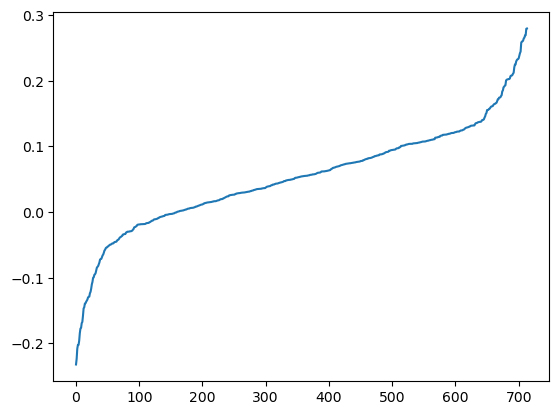

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (307501, 731)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
7/7 - 4s - loss: 1.0854 - mse: 1.0002 - weighted_mse: 0.9986 - cosine_similarity: 0.0591 - val_loss: 0.7996 - val_mse: 1.0003 - val_weighted_mse: 0.9999 - val_cosine_similarity: 0.0054 - 4s/epoch - 542ms/step
Epoch 2/1000
7/7 - 1s - loss: 1.0852 - mse: 1.0002 - weighted_mse: 0.9984 - cosine_similarity: 0.0661 - val_loss: 0.7995 - val_mse: 1.0004 - val_weighted_mse: 0.9999 - val_cosine_similarity: 0.0106 - 945ms/epoch - 135ms/step
Epoch 3/1000
7/7 - 1s - loss: 1.0847 - mse: 1.0002 - weighted_mse: 0.9980 - cosine_similarity: 0.0783 - val_loss: 0.7995 - val_mse: 1.0005 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0165 - 896ms/epoch - 128ms/step
Epoch 4/1000
7/7 - 1s - loss: 1.0840 - mse: 1.0003 - weighted_mse: 0.9973 - cosine_similarity: 0.0929 - val_loss: 0.7994 - val_mse: 1.0006 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0258 - 903ms/epoch - 129ms/step
Epoch 5/1000
7/7 - 1s - loss: 1.0830 - mse: 1

INFO:tensorflow:Assets written to: /tmp/tmpx4fljdk1/assets
2022-11-22 23:50:10.783012: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:50:10.783102: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:50:10.783388: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpx4fljdk1
2022-11-22 23:50:10.785469: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:50:10.785559: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpx4fljdk1
2022-11-22 23:50:10.791946: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:50:10.857735: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpx4fljdk1
2022-11-22 23:50:10.872427: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpve458v74/assets


INFO:tensorflow:Assets written to: /tmp/tmpve458v74/assets
2022-11-22 23:50:12.453692: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:50:12.453783: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:50:12.453991: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpve458v74
2022-11-22 23:50:12.455820: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:50:12.455871: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpve458v74
2022-11-22 23:50:12.462941: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:50:12.530345: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpve458v74
2022-11-22 23:50:12.545143: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbf834x0i/assets


INFO:tensorflow:Assets written to: /tmp/tmpbf834x0i/assets
2022-11-22 23:50:14.100715: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:50:14.100810: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:50:14.101020: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbf834x0i
2022-11-22 23:50:14.102906: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:50:14.102951: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbf834x0i
2022-11-22 23:50:14.109928: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:50:14.177133: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbf834x0i
2022-11-22 23:50:14.192070: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpj8site_j/assets


INFO:tensorflow:Assets written to: /tmp/tmpj8site_j/assets
2022-11-22 23:50:15.770301: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:50:15.770391: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:50:15.770589: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj8site_j
2022-11-22 23:50:15.772430: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:50:15.772478: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpj8site_j
2022-11-22 23:50:15.779446: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:50:15.846487: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpj8site_j
2022-11-22 23:50:15.861618: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa4twlvdk/assets


INFO:tensorflow:Assets written to: /tmp/tmpa4twlvdk/assets
2022-11-22 23:50:17.415610: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:50:17.415701: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:50:17.415906: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa4twlvdk
2022-11-22 23:50:17.417802: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:50:17.417873: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa4twlvdk
2022-11-22 23:50:17.424027: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:50:17.490813: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa4twlvdk
2022-11-22 23:50:17.505952: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp20peymbm/assets


INFO:tensorflow:Assets written to: /tmp/tmp20peymbm/assets
2022-11-22 23:50:19.059644: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:50:19.059725: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:50:19.059923: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp20peymbm
2022-11-22 23:50:19.061813: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:50:19.061858: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp20peymbm
2022-11-22 23:50:19.068055: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:50:19.134634: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp20peymbm
2022-11-22 23:50:19.149827: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdge8op84/assets


INFO:tensorflow:Assets written to: /tmp/tmpdge8op84/assets
2022-11-22 23:50:20.701102: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:50:20.701192: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:50:20.701389: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdge8op84
2022-11-22 23:50:20.703224: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:50:20.703267: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdge8op84
2022-11-22 23:50:20.709486: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:50:20.774817: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdge8op84
2022-11-22 23:50:20.789949: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1qd1gwxd/assets


INFO:tensorflow:Assets written to: /tmp/tmp1qd1gwxd/assets
2022-11-22 23:50:22.343458: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:50:22.343552: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:50:22.343750: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1qd1gwxd
2022-11-22 23:50:22.345590: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:50:22.345634: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1qd1gwxd
2022-11-22 23:50:22.351784: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:50:22.416773: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1qd1gwxd
2022-11-22 23:50:22.431641: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt2p3fjcw/assets


INFO:tensorflow:Assets written to: /tmp/tmpt2p3fjcw/assets
2022-11-22 23:50:23.983229: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:50:23.983323: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:50:23.983525: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt2p3fjcw
2022-11-22 23:50:23.985336: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:50:23.985376: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt2p3fjcw
2022-11-22 23:50:23.992028: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:50:24.058687: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt2p3fjcw
2022-11-22 23:50:24.073719: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppjbh5qxp/assets


INFO:tensorflow:Assets written to: /tmp/tmppjbh5qxp/assets
2022-11-22 23:50:25.614737: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:50:25.614825: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:50:25.615030: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppjbh5qxp
2022-11-22 23:50:25.616864: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:50:25.616909: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppjbh5qxp
2022-11-22 23:50:25.623151: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:50:25.690102: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppjbh5qxp
2022-11-22 23:50:25.705356: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

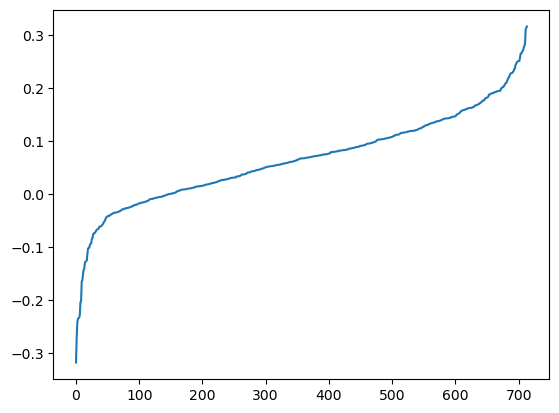

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (283904, 731)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
7/7 - 4s - loss: 1.1319 - mse: 1.0001 - weighted_mse: 0.9986 - cosine_similarity: 0.0660 - val_loss: 0.6910 - val_mse: 1.0003 - val_weighted_mse: 0.9999 - val_cosine_similarity: 0.0163 - 4s/epoch - 509ms/step
Epoch 2/1000
7/7 - 1s - loss: 1.1317 - mse: 1.0002 - weighted_mse: 0.9984 - cosine_similarity: 0.0727 - val_loss: 0.6909 - val_mse: 1.0003 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0189 - 964ms/epoch - 138ms/step
Epoch 3/1000
7/7 - 1s - loss: 1.1311 - mse: 1.0002 - weighted_mse: 0.9979 - cosine_similarity: 0.0856 - val_loss: 0.6909 - val_mse: 1.0004 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0259 - 975ms/epoch - 139ms/step
Epoch 4/1000
7/7 - 1s - loss: 1.1302 - mse: 1.0002 - weighted_mse: 0.9971 - cosine_similarity: 0.1012 - val_loss: 0.6908 - val_mse: 1.0005 - val_weighted_mse: 0.9996 - val_cosine_similarity: 0.0304 - 985ms/epoch - 141ms/step
Epoch 5/1000
7/7 - 1s - loss: 1.1291 - mse: 1

INFO:tensorflow:Assets written to: /tmp/tmpg96a2dtv/assets
2022-11-23 00:18:41.997570: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:18:41.997661: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:18:41.997886: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpg96a2dtv
2022-11-23 00:18:41.999763: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:18:41.999813: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpg96a2dtv
2022-11-23 00:18:42.006235: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:18:42.072426: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpg96a2dtv
2022-11-23 00:18:42.087183: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptabme9hg/assets


INFO:tensorflow:Assets written to: /tmp/tmptabme9hg/assets
2022-11-23 00:18:43.615950: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:18:43.616044: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:18:43.616243: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptabme9hg
2022-11-23 00:18:43.618125: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:18:43.618171: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptabme9hg
2022-11-23 00:18:43.624397: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:18:43.690472: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptabme9hg
2022-11-23 00:18:43.705261: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmjeamm20/assets


INFO:tensorflow:Assets written to: /tmp/tmpmjeamm20/assets
2022-11-23 00:18:45.243371: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:18:45.243460: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:18:45.243654: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmjeamm20
2022-11-23 00:18:45.245466: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:18:45.245541: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmjeamm20
2022-11-23 00:18:45.251764: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:18:45.317119: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmjeamm20
2022-11-23 00:18:45.332208: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzpi_kfmu/assets


INFO:tensorflow:Assets written to: /tmp/tmpzpi_kfmu/assets
2022-11-23 00:18:47.573681: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:18:47.573765: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:18:47.573957: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzpi_kfmu
2022-11-23 00:18:47.577930: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:18:47.577991: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzpi_kfmu
2022-11-23 00:18:47.592326: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:18:47.727019: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzpi_kfmu
2022-11-23 00:18:47.758246: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdph4a3p3/assets


INFO:tensorflow:Assets written to: /tmp/tmpdph4a3p3/assets
2022-11-23 00:18:50.963222: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:18:50.963310: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:18:50.963508: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdph4a3p3
2022-11-23 00:18:50.967521: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:18:50.967582: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdph4a3p3
2022-11-23 00:18:50.979901: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:18:51.121981: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdph4a3p3
2022-11-23 00:18:51.153112: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbpf0vcj4/assets


INFO:tensorflow:Assets written to: /tmp/tmpbpf0vcj4/assets
2022-11-23 00:18:54.446740: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:18:54.446825: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:18:54.447895: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbpf0vcj4
2022-11-23 00:18:54.451584: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:18:54.451777: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbpf0vcj4
2022-11-23 00:18:54.464690: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:18:54.609003: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbpf0vcj4
2022-11-23 00:18:54.641123: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqw66we8b/assets


INFO:tensorflow:Assets written to: /tmp/tmpqw66we8b/assets
2022-11-23 00:18:57.947838: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:18:57.948132: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:18:57.949234: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqw66we8b
2022-11-23 00:18:57.952154: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:18:57.952342: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqw66we8b
2022-11-23 00:18:57.966521: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:18:58.103783: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqw66we8b
2022-11-23 00:18:58.136455: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvjurpn2z/assets


INFO:tensorflow:Assets written to: /tmp/tmpvjurpn2z/assets
2022-11-23 00:19:01.875384: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:19:01.875478: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:19:01.875672: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvjurpn2z
2022-11-23 00:19:01.880275: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:19:01.880926: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvjurpn2z
2022-11-23 00:19:01.896940: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:19:02.068931: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvjurpn2z
2022-11-23 00:19:02.108282: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_6nd82ff/assets


INFO:tensorflow:Assets written to: /tmp/tmp_6nd82ff/assets
2022-11-23 00:19:06.025199: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:19:06.025288: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:19:06.025485: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_6nd82ff
2022-11-23 00:19:06.029407: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:19:06.029460: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_6nd82ff
2022-11-23 00:19:06.043912: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:19:06.212729: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_6nd82ff
2022-11-23 00:19:06.251455: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsao3tp2_/assets


INFO:tensorflow:Assets written to: /tmp/tmpsao3tp2_/assets
2022-11-23 00:19:09.396520: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:19:09.396605: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:19:09.396802: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsao3tp2_
2022-11-23 00:19:09.400719: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:19:09.400782: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsao3tp2_
2022-11-23 00:19:09.412860: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:19:09.533152: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsao3tp2_
2022-11-23 00:19:09.559756: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

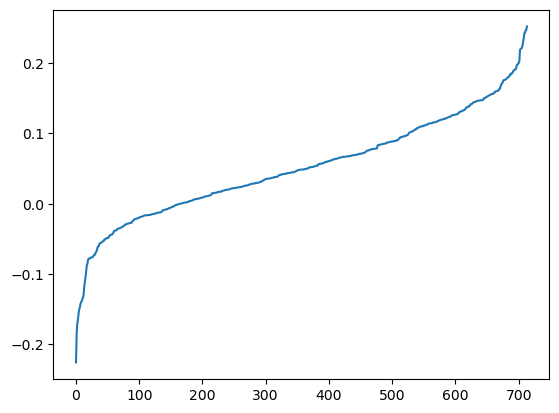

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (244756, 731)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
6/6 - 3s - loss: 1.1222 - mse: 1.0002 - weighted_mse: 0.9985 - cosine_similarity: 0.0571 - val_loss: 0.7139 - val_mse: 1.0003 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0212 - 3s/epoch - 555ms/step
Epoch 2/1000
6/6 - 1s - loss: 1.1220 - mse: 1.0002 - weighted_mse: 0.9984 - cosine_similarity: 0.0605 - val_loss: 0.7139 - val_mse: 1.0003 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0239 - 784ms/epoch - 131ms/step
Epoch 3/1000
6/6 - 1s - loss: 1.1216 - mse: 1.0002 - weighted_mse: 0.9980 - cosine_similarity: 0.0719 - val_loss: 0.7139 - val_mse: 1.0003 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0265 - 757ms/epoch - 126ms/step
Epoch 4/1000
6/6 - 1s - loss: 1.1209 - mse: 1.0002 - weighted_mse: 0.9974 - cosine_similarity: 0.0863 - val_loss: 0.7138 - val_mse: 1.0004 - val_weighted_mse: 0.9996 - val_cosine_similarity: 0.0305 - 784ms/epoch - 131ms/step
Epoch 5/1000
6/6 - 1s - loss: 1.1200 - mse: 1

INFO:tensorflow:Assets written to: /tmp/tmpgw3ijkcc/assets
2022-11-23 00:33:31.899065: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:33:31.899155: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:33:31.899350: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgw3ijkcc
2022-11-23 00:33:31.901181: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:33:31.901221: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgw3ijkcc
2022-11-23 00:33:31.907740: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:33:31.972883: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgw3ijkcc
2022-11-23 00:33:31.987259: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0fdfsn31/assets


INFO:tensorflow:Assets written to: /tmp/tmp0fdfsn31/assets
2022-11-23 00:33:33.465532: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:33:33.465610: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:33:33.465795: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0fdfsn31
2022-11-23 00:33:33.467559: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:33:33.467596: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0fdfsn31
2022-11-23 00:33:33.473644: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:33:33.536469: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0fdfsn31
2022-11-23 00:33:33.550407: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfu302lig/assets


INFO:tensorflow:Assets written to: /tmp/tmpfu302lig/assets
2022-11-23 00:33:35.033259: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:33:35.033348: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:33:35.033560: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfu302lig
2022-11-23 00:33:35.035366: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:33:35.035409: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfu302lig
2022-11-23 00:33:35.041706: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:33:35.105781: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfu302lig
2022-11-23 00:33:35.120391: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1ku4w77d/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ku4w77d/assets
2022-11-23 00:33:36.605928: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:33:36.606020: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:33:36.606217: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1ku4w77d
2022-11-23 00:33:36.608056: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:33:36.608098: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1ku4w77d
2022-11-23 00:33:36.614361: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:33:36.679129: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1ku4w77d
2022-11-23 00:33:36.693398: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmzgzuw4i/assets


INFO:tensorflow:Assets written to: /tmp/tmpmzgzuw4i/assets
2022-11-23 00:33:38.179967: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:33:38.180053: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:33:38.180245: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmzgzuw4i
2022-11-23 00:33:38.182054: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:33:38.182092: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmzgzuw4i
2022-11-23 00:33:38.188244: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:33:38.252059: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmzgzuw4i
2022-11-23 00:33:38.266512: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjpsxjytm/assets


INFO:tensorflow:Assets written to: /tmp/tmpjpsxjytm/assets
2022-11-23 00:33:39.733188: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:33:39.733273: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:33:39.733474: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjpsxjytm
2022-11-23 00:33:39.735272: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:33:39.735313: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjpsxjytm
2022-11-23 00:33:39.741467: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:33:39.806466: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjpsxjytm
2022-11-23 00:33:39.820750: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpblbf5kzv/assets


INFO:tensorflow:Assets written to: /tmp/tmpblbf5kzv/assets
2022-11-23 00:33:41.294751: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:33:41.294838: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:33:41.295041: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpblbf5kzv
2022-11-23 00:33:41.296827: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:33:41.296865: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpblbf5kzv
2022-11-23 00:33:41.302961: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:33:41.365196: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpblbf5kzv
2022-11-23 00:33:41.379234: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppr77btzm/assets


INFO:tensorflow:Assets written to: /tmp/tmppr77btzm/assets
2022-11-23 00:33:42.844218: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:33:42.844298: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:33:42.844489: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppr77btzm
2022-11-23 00:33:42.846296: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:33:42.846335: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppr77btzm
2022-11-23 00:33:42.852444: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:33:42.917081: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppr77btzm
2022-11-23 00:33:42.931224: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpke0b38s8/assets


INFO:tensorflow:Assets written to: /tmp/tmpke0b38s8/assets
2022-11-23 00:33:44.394339: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:33:44.394421: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:33:44.394610: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpke0b38s8
2022-11-23 00:33:44.396399: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:33:44.396437: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpke0b38s8
2022-11-23 00:33:44.402515: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:33:44.466035: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpke0b38s8
2022-11-23 00:33:44.480523: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnx4o2jow/assets


INFO:tensorflow:Assets written to: /tmp/tmpnx4o2jow/assets
2022-11-23 00:33:45.949130: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:33:45.949223: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:33:45.949415: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnx4o2jow
2022-11-23 00:33:45.951200: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:33:45.951242: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnx4o2jow
2022-11-23 00:33:45.957320: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:33:46.022031: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnx4o2jow
2022-11-23 00:33:46.036416: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

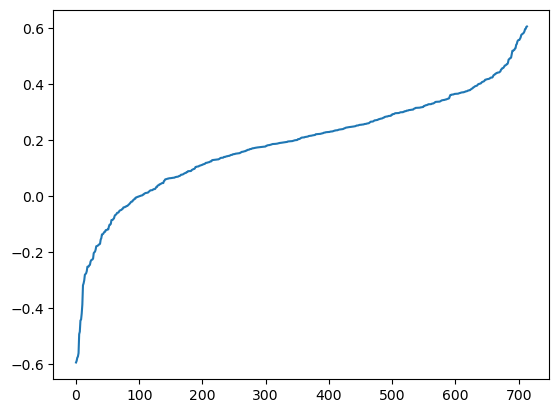

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (226471, 731)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
5/5 - 3s - loss: 0.9865 - mse: 1.0003 - weighted_mse: 0.9988 - cosine_similarity: 0.0458 - val_loss: 1.0283 - val_mse: 1.0001 - val_weighted_mse: 0.9996 - val_cosine_similarity: 0.0466 - 3s/epoch - 674ms/step
Epoch 2/1000
5/5 - 1s - loss: 0.9865 - mse: 1.0003 - weighted_mse: 0.9988 - cosine_similarity: 0.0487 - val_loss: 1.0282 - val_mse: 1.0001 - val_weighted_mse: 0.9995 - val_cosine_similarity: 0.0562 - 738ms/epoch - 148ms/step
Epoch 3/1000
5/5 - 1s - loss: 0.9862 - mse: 1.0003 - weighted_mse: 0.9985 - cosine_similarity: 0.0567 - val_loss: 1.0281 - val_mse: 1.0001 - val_weighted_mse: 0.9994 - val_cosine_similarity: 0.0657 - 771ms/epoch - 154ms/step
Epoch 4/1000
5/5 - 1s - loss: 0.9858 - mse: 1.0003 - weighted_mse: 0.9981 - cosine_similarity: 0.0653 - val_loss: 1.0279 - val_mse: 1.0002 - val_weighted_mse: 0.9992 - val_cosine_similarity: 0.0760 - 737ms/epoch - 147ms/step
Epoch 5/1000
5/5 - 1s - loss: 0.9852 - mse: 1

INFO:tensorflow:Assets written to: /tmp/tmp_j6ln43q/assets
2022-11-23 00:50:24.087421: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:50:24.087519: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:50:24.087726: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_j6ln43q
2022-11-23 00:50:24.089632: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:50:24.089679: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_j6ln43q
2022-11-23 00:50:24.096091: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:50:24.162638: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_j6ln43q
2022-11-23 00:50:24.178137: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp744q9ah0/assets


INFO:tensorflow:Assets written to: /tmp/tmp744q9ah0/assets
2022-11-23 00:50:25.741321: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:50:25.741423: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:50:25.741641: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp744q9ah0
2022-11-23 00:50:25.743511: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:50:25.743557: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp744q9ah0
2022-11-23 00:50:25.749989: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:50:25.817157: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp744q9ah0
2022-11-23 00:50:25.832638: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpy228f1e8/assets


INFO:tensorflow:Assets written to: /tmp/tmpy228f1e8/assets
2022-11-23 00:50:27.391874: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:50:27.391978: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:50:27.392171: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpy228f1e8
2022-11-23 00:50:27.394073: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:50:27.394122: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpy228f1e8
2022-11-23 00:50:27.400465: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:50:27.466717: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpy228f1e8
2022-11-23 00:50:27.482131: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4eryuow8/assets


INFO:tensorflow:Assets written to: /tmp/tmp4eryuow8/assets
2022-11-23 00:50:29.036384: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:50:29.036481: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:50:29.036675: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4eryuow8
2022-11-23 00:50:29.038561: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:50:29.038610: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4eryuow8
2022-11-23 00:50:29.044986: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:50:29.111027: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4eryuow8
2022-11-23 00:50:29.126231: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3e7iz7j6/assets


INFO:tensorflow:Assets written to: /tmp/tmp3e7iz7j6/assets
2022-11-23 00:50:30.689788: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:50:30.689880: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:50:30.690073: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3e7iz7j6
2022-11-23 00:50:30.691909: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:50:30.691960: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3e7iz7j6
2022-11-23 00:50:30.698445: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:50:30.767212: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3e7iz7j6
2022-11-23 00:50:30.782986: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkekmmv10/assets


INFO:tensorflow:Assets written to: /tmp/tmpkekmmv10/assets
2022-11-23 00:50:32.397381: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:50:32.397484: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:50:32.397712: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkekmmv10
2022-11-23 00:50:32.399593: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:50:32.399642: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkekmmv10
2022-11-23 00:50:32.406103: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:50:32.482678: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkekmmv10
2022-11-23 00:50:32.498907: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo4059rfq/assets


INFO:tensorflow:Assets written to: /tmp/tmpo4059rfq/assets
2022-11-23 00:50:34.082713: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:50:34.082807: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:50:34.083015: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo4059rfq
2022-11-23 00:50:34.084848: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:50:34.084909: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo4059rfq
2022-11-23 00:50:34.091434: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:50:34.157872: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo4059rfq
2022-11-23 00:50:34.173484: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpp3lkj16v/assets


INFO:tensorflow:Assets written to: /tmp/tmpp3lkj16v/assets
2022-11-23 00:50:35.744143: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:50:35.744240: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:50:35.744434: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp3lkj16v
2022-11-23 00:50:35.746320: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:50:35.746374: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp3lkj16v
2022-11-23 00:50:35.752839: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:50:35.820604: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpp3lkj16v
2022-11-23 00:50:35.836124: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2bq4d0tl/assets


INFO:tensorflow:Assets written to: /tmp/tmp2bq4d0tl/assets
2022-11-23 00:50:37.415722: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:50:37.415818: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:50:37.416024: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2bq4d0tl
2022-11-23 00:50:37.417905: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:50:37.417953: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2bq4d0tl
2022-11-23 00:50:37.424441: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:50:37.494382: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2bq4d0tl
2022-11-23 00:50:37.511102: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpufiqkeey/assets


INFO:tensorflow:Assets written to: /tmp/tmpufiqkeey/assets
2022-11-23 00:50:39.096971: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:50:39.097071: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:50:39.097271: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpufiqkeey
2022-11-23 00:50:39.099203: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:50:39.099258: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpufiqkeey
2022-11-23 00:50:39.105974: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:50:39.177016: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpufiqkeey
2022-11-23 00:50:39.193426: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

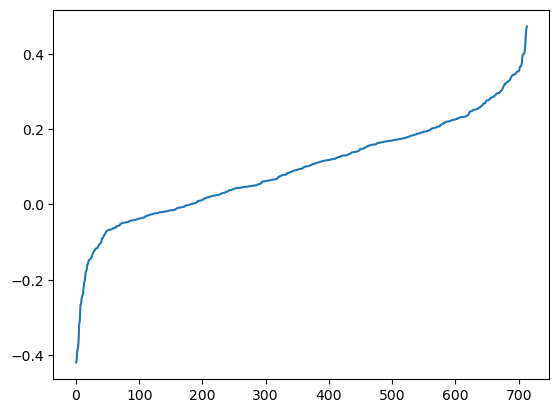

return without cost statistics
mean 0.0029602257040333055
std 0.035243207232053694
sharpe 0.0839942200646535
double sharpe 1.0970408743711364
max drawdown 17.053116991420683
min -1.1471399681123262
min sharpe 0.002580527037955533
return with cost statistics
mean 0.0019447998443338009
std 0.03524761405668683
sharpe 0.05517536140761427
double sharpe 0.6692200468064818
max drawdown 17.18761699780909
min -1.147639968136075
min sharpe 0.0016946079766570201


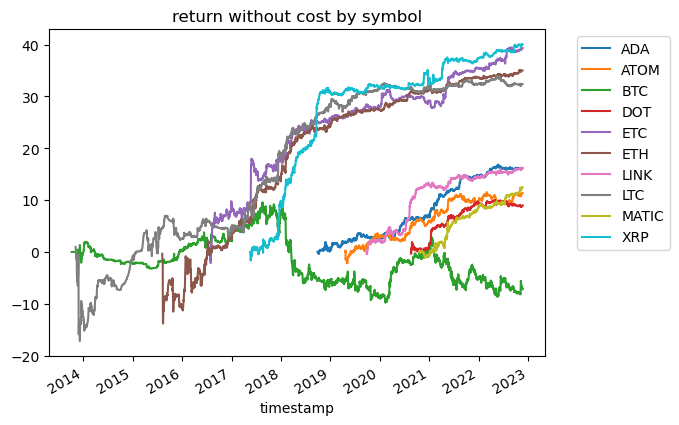

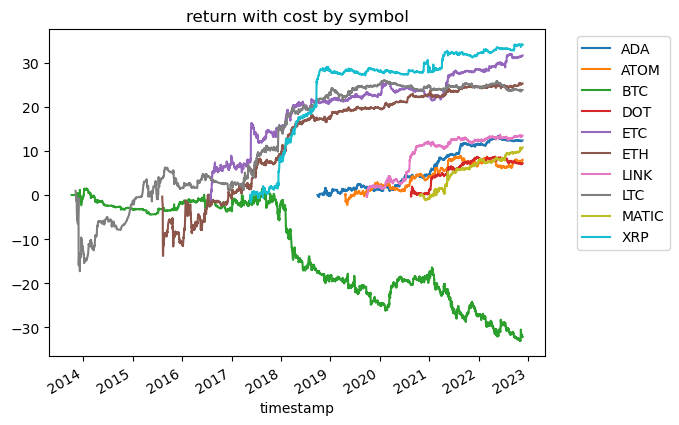

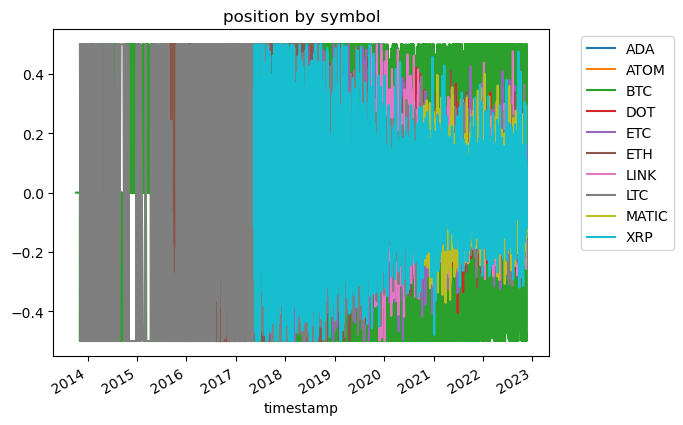

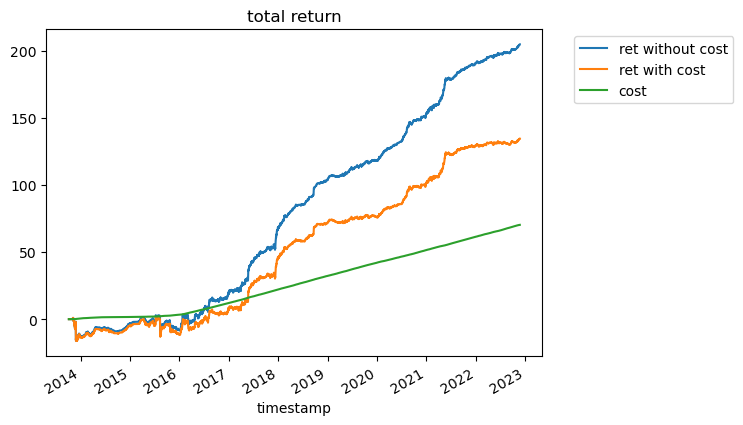

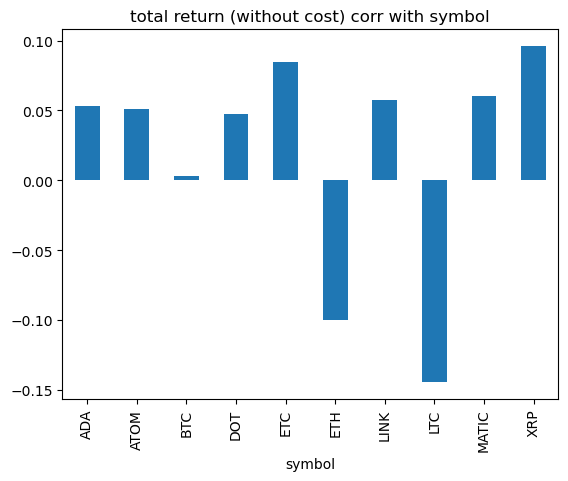

return without cost statistics
mean 0.0028786953668325033
std 0.016852997516921497
sharpe 0.1708120685321473
double sharpe 1.1553866815480447
max drawdown 3.80165651681282
min -0.1590665811038654
min sharpe 0.01809742402744425
return with cost statistics
mean 0.0018527123286643616
std 0.01685170973419799
sharpe 0.10994209833228749
double sharpe 0.656284292682339
max drawdown 4.726150561413913
min -0.1590665811038654
min sharpe 0.011647401457975637


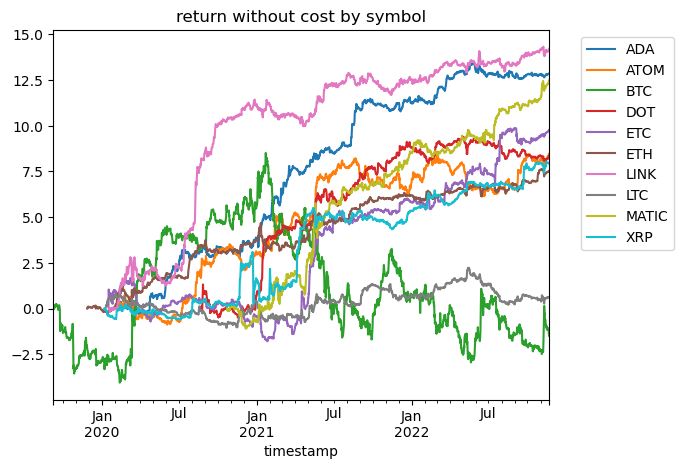

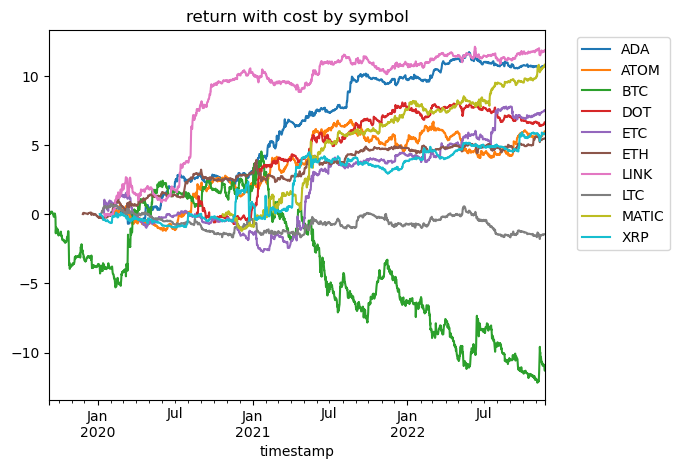

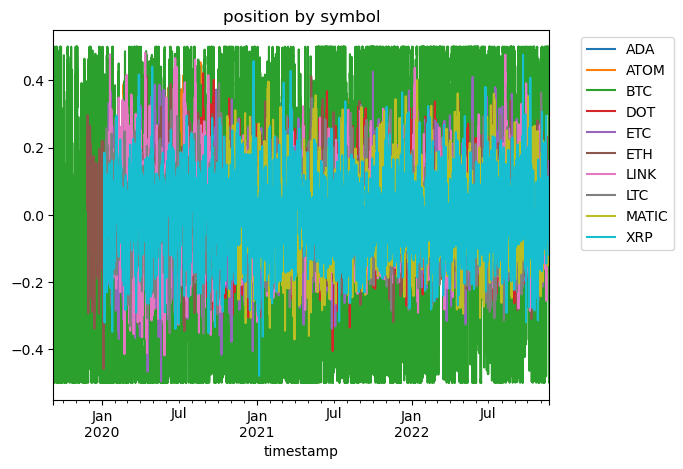

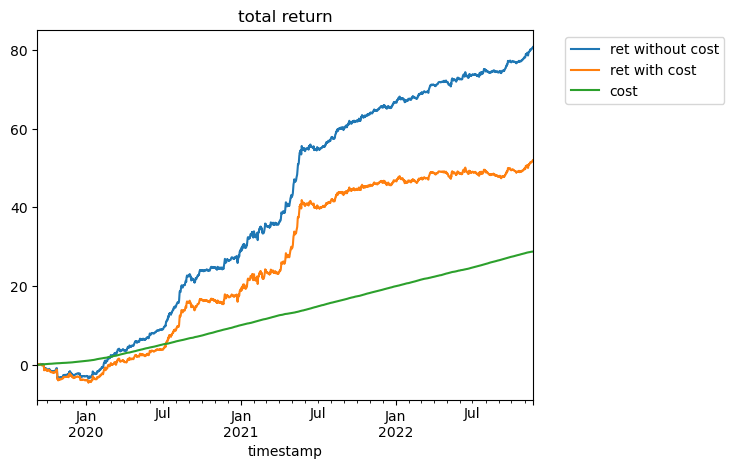

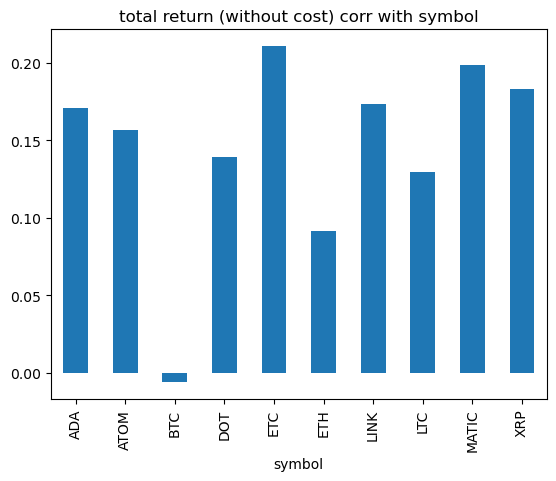

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (351166, 731)
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[

INFO:tensorflow:Assets written to: /tmp/tmpmwtwdbqv/assets
2022-11-23 03:32:47.655055: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:32:47.655276: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:32:47.663430: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmwtwdbqv
2022-11-23 03:32:47.669149: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:32:47.669204: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmwtwdbqv
2022-11-23 03:32:47.688153: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:32:47.769926: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmwtwdbqv
2022-11-23 03:32:47.790401: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd3h4af3g/assets


INFO:tensorflow:Assets written to: /tmp/tmpd3h4af3g/assets
2022-11-23 03:32:49.553875: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:32:49.553959: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:32:49.554166: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd3h4af3g
2022-11-23 03:32:49.555964: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:32:49.556016: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd3h4af3g
2022-11-23 03:32:49.562113: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:32:49.626068: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd3h4af3g
2022-11-23 03:32:49.640527: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmgpvdbbb/assets


INFO:tensorflow:Assets written to: /tmp/tmpmgpvdbbb/assets
2022-11-23 03:32:51.144216: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:32:51.144305: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:32:51.144503: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmgpvdbbb
2022-11-23 03:32:51.146365: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:32:51.146411: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmgpvdbbb
2022-11-23 03:32:51.152514: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:32:51.216891: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmgpvdbbb
2022-11-23 03:32:51.231263: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjoewqe2y/assets


INFO:tensorflow:Assets written to: /tmp/tmpjoewqe2y/assets
2022-11-23 03:32:52.727894: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:32:52.727987: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:32:52.728177: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjoewqe2y
2022-11-23 03:32:52.729978: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:32:52.730017: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjoewqe2y
2022-11-23 03:32:52.735947: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:32:52.805469: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjoewqe2y
2022-11-23 03:32:52.819713: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcio1p3v_/assets


INFO:tensorflow:Assets written to: /tmp/tmpcio1p3v_/assets
2022-11-23 03:32:54.339124: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:32:54.339217: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:32:54.339417: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcio1p3v_
2022-11-23 03:32:54.341311: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:32:54.341359: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcio1p3v_
2022-11-23 03:32:54.347593: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:32:54.412716: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcio1p3v_
2022-11-23 03:32:54.427545: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpn817b005/assets


INFO:tensorflow:Assets written to: /tmp/tmpn817b005/assets
2022-11-23 03:32:55.950095: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:32:55.950186: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:32:55.950381: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpn817b005
2022-11-23 03:32:55.952201: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:32:55.952245: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpn817b005
2022-11-23 03:32:55.959620: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:32:56.026924: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpn817b005
2022-11-23 03:32:56.041878: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptl0h_5vx/assets


INFO:tensorflow:Assets written to: /tmp/tmptl0h_5vx/assets
2022-11-23 03:32:57.584362: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:32:57.584462: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:32:57.584658: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptl0h_5vx
2022-11-23 03:32:57.586921: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:32:57.586965: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptl0h_5vx
2022-11-23 03:32:57.601733: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:32:57.670778: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptl0h_5vx
2022-11-23 03:32:57.684949: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphfiam7tp/assets


INFO:tensorflow:Assets written to: /tmp/tmphfiam7tp/assets
2022-11-23 03:32:59.239559: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:32:59.239644: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:32:59.239843: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphfiam7tp
2022-11-23 03:32:59.242132: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:32:59.242179: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphfiam7tp
2022-11-23 03:32:59.257054: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:32:59.331176: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphfiam7tp
2022-11-23 03:32:59.346232: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp09tx9hpy/assets


INFO:tensorflow:Assets written to: /tmp/tmp09tx9hpy/assets
2022-11-23 03:33:00.905467: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:00.905564: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:00.905760: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp09tx9hpy
2022-11-23 03:33:00.908027: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:00.908075: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp09tx9hpy
2022-11-23 03:33:00.922663: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:00.994445: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp09tx9hpy
2022-11-23 03:33:01.008984: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt1_sxonf/assets


INFO:tensorflow:Assets written to: /tmp/tmpt1_sxonf/assets
2022-11-23 03:33:05.284559: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:05.284647: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:05.284843: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt1_sxonf
2022-11-23 03:33:05.288093: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:05.288164: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt1_sxonf
2022-11-23 03:33:05.299687: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:05.377712: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt1_sxonf
2022-11-23 03:33:05.396519: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvba0r17_/assets


INFO:tensorflow:Assets written to: /tmp/tmpvba0r17_/assets
2022-11-23 03:33:07.003867: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:07.003958: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:07.004152: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvba0r17_
2022-11-23 03:33:07.006661: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:07.006708: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvba0r17_
2022-11-23 03:33:07.015471: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:07.087439: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvba0r17_
2022-11-23 03:33:07.104598: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa5a5j7y9/assets


INFO:tensorflow:Assets written to: /tmp/tmpa5a5j7y9/assets
2022-11-23 03:33:08.667464: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:08.667546: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:08.667740: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa5a5j7y9
2022-11-23 03:33:08.669859: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:08.669904: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa5a5j7y9
2022-11-23 03:33:08.677210: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:08.745485: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa5a5j7y9
2022-11-23 03:33:08.761103: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfs11o3cg/assets


INFO:tensorflow:Assets written to: /tmp/tmpfs11o3cg/assets
2022-11-23 03:33:10.307210: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:10.307295: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:10.307501: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfs11o3cg
2022-11-23 03:33:10.309564: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:10.309604: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfs11o3cg
2022-11-23 03:33:10.316517: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:10.386190: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfs11o3cg
2022-11-23 03:33:10.402714: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpp96dixu7/assets


INFO:tensorflow:Assets written to: /tmp/tmpp96dixu7/assets
2022-11-23 03:33:11.934853: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:11.934943: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:11.935134: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp96dixu7
2022-11-23 03:33:11.937126: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:11.937173: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp96dixu7
2022-11-23 03:33:11.944149: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:12.013960: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpp96dixu7
2022-11-23 03:33:12.028416: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxy_qaq2u/assets


INFO:tensorflow:Assets written to: /tmp/tmpxy_qaq2u/assets
2022-11-23 03:33:13.545241: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:13.545329: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:13.545539: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxy_qaq2u
2022-11-23 03:33:13.547420: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:13.547464: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxy_qaq2u
2022-11-23 03:33:13.554114: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:13.619621: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxy_qaq2u
2022-11-23 03:33:13.633909: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp52piyqii/assets


INFO:tensorflow:Assets written to: /tmp/tmp52piyqii/assets
2022-11-23 03:33:15.133906: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:15.134002: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:15.134200: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp52piyqii
2022-11-23 03:33:15.136097: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:15.136144: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp52piyqii
2022-11-23 03:33:15.142779: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:15.208786: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp52piyqii
2022-11-23 03:33:15.223893: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkneyfam1/assets


INFO:tensorflow:Assets written to: /tmp/tmpkneyfam1/assets
2022-11-23 03:33:16.719689: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:16.719772: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:16.719979: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkneyfam1
2022-11-23 03:33:16.721822: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:16.721869: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkneyfam1
2022-11-23 03:33:16.728162: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:16.793454: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkneyfam1
2022-11-23 03:33:16.807583: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4q_8fxmu/assets


INFO:tensorflow:Assets written to: /tmp/tmp4q_8fxmu/assets
2022-11-23 03:33:18.298399: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:18.298482: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:18.298675: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4q_8fxmu
2022-11-23 03:33:18.300491: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:18.300530: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4q_8fxmu
2022-11-23 03:33:18.306824: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:18.372226: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4q_8fxmu
2022-11-23 03:33:18.386669: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa_m1zjhh/assets


INFO:tensorflow:Assets written to: /tmp/tmpa_m1zjhh/assets
2022-11-23 03:33:19.866263: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:19.866347: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:19.866544: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa_m1zjhh
2022-11-23 03:33:19.868391: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:19.868430: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa_m1zjhh
2022-11-23 03:33:19.874574: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:19.937683: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa_m1zjhh
2022-11-23 03:33:19.951968: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1glz1mrr/assets


INFO:tensorflow:Assets written to: /tmp/tmp1glz1mrr/assets
2022-11-23 03:33:21.443838: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:21.443935: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:21.444131: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1glz1mrr
2022-11-23 03:33:21.446025: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:21.446070: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1glz1mrr
2022-11-23 03:33:21.452507: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:21.517070: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1glz1mrr
2022-11-23 03:33:21.531755: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpoet98jv4/assets


INFO:tensorflow:Assets written to: /tmp/tmpoet98jv4/assets
2022-11-23 03:33:23.043231: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:23.043320: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:23.043517: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpoet98jv4
2022-11-23 03:33:23.045348: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:23.045391: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpoet98jv4
2022-11-23 03:33:23.051694: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:23.116551: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpoet98jv4
2022-11-23 03:33:23.131249: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqvv9qe1j/assets


INFO:tensorflow:Assets written to: /tmp/tmpqvv9qe1j/assets
2022-11-23 03:33:24.640213: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:24.640301: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:24.640494: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqvv9qe1j
2022-11-23 03:33:24.642325: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:24.642369: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqvv9qe1j
2022-11-23 03:33:24.648434: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:24.711530: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqvv9qe1j
2022-11-23 03:33:24.725531: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyznbcfxv/assets


INFO:tensorflow:Assets written to: /tmp/tmpyznbcfxv/assets
2022-11-23 03:33:26.218129: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:26.218217: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:26.218417: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyznbcfxv
2022-11-23 03:33:26.220307: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:26.220352: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyznbcfxv
2022-11-23 03:33:26.226592: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:26.290572: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyznbcfxv
2022-11-23 03:33:26.304839: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4q_8qt04/assets


INFO:tensorflow:Assets written to: /tmp/tmp4q_8qt04/assets
2022-11-23 03:33:27.799689: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:27.799769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:27.799975: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4q_8qt04
2022-11-23 03:33:27.801833: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:27.801871: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4q_8qt04
2022-11-23 03:33:27.808018: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:27.872798: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4q_8qt04
2022-11-23 03:33:27.886990: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp66pfhpq2/assets


INFO:tensorflow:Assets written to: /tmp/tmp66pfhpq2/assets
2022-11-23 03:33:29.370330: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:29.370417: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:29.370613: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp66pfhpq2
2022-11-23 03:33:29.372448: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:29.372492: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp66pfhpq2
2022-11-23 03:33:29.378554: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:29.442083: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp66pfhpq2
2022-11-23 03:33:29.456335: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwkd9cszi/assets


INFO:tensorflow:Assets written to: /tmp/tmpwkd9cszi/assets
2022-11-23 03:33:30.948846: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:30.948950: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:30.949145: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwkd9cszi
2022-11-23 03:33:30.951035: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:30.951079: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwkd9cszi
2022-11-23 03:33:30.957275: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:31.020762: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwkd9cszi
2022-11-23 03:33:31.034963: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpi5d98b0w/assets


INFO:tensorflow:Assets written to: /tmp/tmpi5d98b0w/assets
2022-11-23 03:33:32.538989: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:32.539074: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:32.539272: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpi5d98b0w
2022-11-23 03:33:32.541082: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:32.541122: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpi5d98b0w
2022-11-23 03:33:32.547256: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:32.610728: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpi5d98b0w
2022-11-23 03:33:32.625264: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7a7f6ggf/assets


INFO:tensorflow:Assets written to: /tmp/tmp7a7f6ggf/assets
2022-11-23 03:33:34.126612: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:34.126698: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:34.126897: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7a7f6ggf
2022-11-23 03:33:34.128729: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:34.128772: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7a7f6ggf
2022-11-23 03:33:34.134995: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:34.201950: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7a7f6ggf
2022-11-23 03:33:34.216484: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8ftxh88y/assets


INFO:tensorflow:Assets written to: /tmp/tmp8ftxh88y/assets
2022-11-23 03:33:35.727800: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:35.727869: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:35.728073: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8ftxh88y
2022-11-23 03:33:35.730027: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:35.730065: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8ftxh88y
2022-11-23 03:33:35.739337: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:35.807072: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8ftxh88y
2022-11-23 03:33:35.821408: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_fwlmobg/assets


INFO:tensorflow:Assets written to: /tmp/tmp_fwlmobg/assets
2022-11-23 03:33:37.361905: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:37.362004: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:37.362200: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_fwlmobg
2022-11-23 03:33:37.364238: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:37.364287: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_fwlmobg
2022-11-23 03:33:37.373722: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:37.440385: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_fwlmobg
2022-11-23 03:33:37.455220: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf3c2k9gy/assets


INFO:tensorflow:Assets written to: /tmp/tmpf3c2k9gy/assets
2022-11-23 03:33:38.999975: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:39.000068: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:39.000271: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf3c2k9gy
2022-11-23 03:33:39.002566: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:39.002617: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf3c2k9gy
2022-11-23 03:33:39.017892: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:39.087361: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf3c2k9gy
2022-11-23 03:33:39.102434: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplgtp6at4/assets


INFO:tensorflow:Assets written to: /tmp/tmplgtp6at4/assets
2022-11-23 03:33:44.677978: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:44.678069: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:44.678277: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplgtp6at4
2022-11-23 03:33:44.681574: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:44.681628: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplgtp6at4
2022-11-23 03:33:44.693613: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:44.776467: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplgtp6at4
2022-11-23 03:33:44.797140: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph5n57_xs/assets


INFO:tensorflow:Assets written to: /tmp/tmph5n57_xs/assets
2022-11-23 03:33:46.436783: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:46.436873: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:46.437080: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph5n57_xs
2022-11-23 03:33:46.439679: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:46.439728: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph5n57_xs
2022-11-23 03:33:46.449138: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:46.523097: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph5n57_xs
2022-11-23 03:33:46.540834: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpn3tm8d2b/assets


INFO:tensorflow:Assets written to: /tmp/tmpn3tm8d2b/assets
2022-11-23 03:33:48.136645: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:48.136738: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:48.136937: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpn3tm8d2b
2022-11-23 03:33:48.139391: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:48.139444: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpn3tm8d2b
2022-11-23 03:33:48.147829: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:48.220763: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpn3tm8d2b
2022-11-23 03:33:48.237227: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzt1x47au/assets


INFO:tensorflow:Assets written to: /tmp/tmpzt1x47au/assets
2022-11-23 03:33:49.798295: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:49.798389: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:49.798588: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzt1x47au
2022-11-23 03:33:49.800850: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:49.800918: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzt1x47au
2022-11-23 03:33:49.808637: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:49.880699: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzt1x47au
2022-11-23 03:33:49.897671: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpl3_ycvse/assets


INFO:tensorflow:Assets written to: /tmp/tmpl3_ycvse/assets
2022-11-23 03:33:51.459819: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:51.459908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:51.460117: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpl3_ycvse
2022-11-23 03:33:51.462273: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:51.462325: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpl3_ycvse
2022-11-23 03:33:51.469471: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:51.538964: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpl3_ycvse
2022-11-23 03:33:51.554826: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7v5c826x/assets


INFO:tensorflow:Assets written to: /tmp/tmp7v5c826x/assets
2022-11-23 03:33:53.102753: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:53.102853: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:53.103057: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7v5c826x
2022-11-23 03:33:53.105098: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:53.105145: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7v5c826x
2022-11-23 03:33:53.112041: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:53.179718: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7v5c826x
2022-11-23 03:33:53.195145: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3g1kz3fk/assets


INFO:tensorflow:Assets written to: /tmp/tmp3g1kz3fk/assets
2022-11-23 03:33:54.754460: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:54.754554: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:54.754758: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3g1kz3fk
2022-11-23 03:33:54.756788: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:54.756834: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3g1kz3fk
2022-11-23 03:33:54.763957: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:54.832858: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3g1kz3fk
2022-11-23 03:33:54.848517: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpolyqu1my/assets


INFO:tensorflow:Assets written to: /tmp/tmpolyqu1my/assets
2022-11-23 03:33:56.412663: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:56.412754: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:56.412962: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpolyqu1my
2022-11-23 03:33:56.414986: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:56.415034: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpolyqu1my
2022-11-23 03:33:56.421862: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:56.491409: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpolyqu1my
2022-11-23 03:33:56.507296: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpucvqbkgk/assets


INFO:tensorflow:Assets written to: /tmp/tmpucvqbkgk/assets
2022-11-23 03:33:58.063953: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:58.064035: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:58.064231: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpucvqbkgk
2022-11-23 03:33:58.066293: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:58.066344: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpucvqbkgk
2022-11-23 03:33:58.073144: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:58.141743: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpucvqbkgk
2022-11-23 03:33:58.157550: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1g9y_ee7/assets


INFO:tensorflow:Assets written to: /tmp/tmp1g9y_ee7/assets
2022-11-23 03:33:59.710056: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:33:59.710150: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:33:59.710349: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1g9y_ee7
2022-11-23 03:33:59.712336: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:33:59.712384: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1g9y_ee7
2022-11-23 03:33:59.719233: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:33:59.791123: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1g9y_ee7
2022-11-23 03:33:59.806453: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3_sps8ni/assets


INFO:tensorflow:Assets written to: /tmp/tmp3_sps8ni/assets
2022-11-23 03:34:01.373020: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:01.373111: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:01.373310: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3_sps8ni
2022-11-23 03:34:01.375278: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:01.375328: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3_sps8ni
2022-11-23 03:34:01.382320: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:01.451757: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3_sps8ni
2022-11-23 03:34:01.467503: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdfo62e2e/assets


INFO:tensorflow:Assets written to: /tmp/tmpdfo62e2e/assets
2022-11-23 03:34:03.020361: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:03.020456: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:03.020655: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdfo62e2e
2022-11-23 03:34:03.022641: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:03.022692: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdfo62e2e
2022-11-23 03:34:03.029542: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:03.098523: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdfo62e2e
2022-11-23 03:34:03.114217: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp804da2e3/assets


INFO:tensorflow:Assets written to: /tmp/tmp804da2e3/assets
2022-11-23 03:34:04.676237: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:04.676327: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:04.676528: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp804da2e3
2022-11-23 03:34:04.678589: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:04.678638: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp804da2e3
2022-11-23 03:34:04.685456: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:04.754691: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp804da2e3
2022-11-23 03:34:04.770114: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkwdaxsjl/assets


INFO:tensorflow:Assets written to: /tmp/tmpkwdaxsjl/assets
2022-11-23 03:34:06.318244: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:06.318338: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:06.318538: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkwdaxsjl
2022-11-23 03:34:06.320518: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:06.320572: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkwdaxsjl
2022-11-23 03:34:06.327297: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:06.395495: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkwdaxsjl
2022-11-23 03:34:06.410660: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4ibxgps7/assets


INFO:tensorflow:Assets written to: /tmp/tmp4ibxgps7/assets
2022-11-23 03:34:07.972695: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:07.972790: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:07.972988: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4ibxgps7
2022-11-23 03:34:07.974950: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:07.975000: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4ibxgps7
2022-11-23 03:34:07.981630: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:08.047712: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4ibxgps7
2022-11-23 03:34:08.063188: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo2wd7chl/assets


INFO:tensorflow:Assets written to: /tmp/tmpo2wd7chl/assets
2022-11-23 03:34:09.608712: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:09.608810: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:09.609025: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo2wd7chl
2022-11-23 03:34:09.611033: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:09.611090: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo2wd7chl
2022-11-23 03:34:09.617905: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:09.684417: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo2wd7chl
2022-11-23 03:34:09.699753: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5d_9o487/assets


INFO:tensorflow:Assets written to: /tmp/tmp5d_9o487/assets
2022-11-23 03:34:11.245839: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:11.245929: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:11.246125: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5d_9o487
2022-11-23 03:34:11.248070: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:11.248120: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5d_9o487
2022-11-23 03:34:11.254427: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:11.320964: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5d_9o487
2022-11-23 03:34:11.336032: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphoay0agn/assets


INFO:tensorflow:Assets written to: /tmp/tmphoay0agn/assets
2022-11-23 03:34:16.051611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:16.051699: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:16.051918: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphoay0agn
2022-11-23 03:34:16.055621: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:16.055676: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphoay0agn
2022-11-23 03:34:16.069414: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:16.167054: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphoay0agn
2022-11-23 03:34:16.191574: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp511llra_/assets


INFO:tensorflow:Assets written to: /tmp/tmp511llra_/assets
2022-11-23 03:34:17.908045: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:17.908138: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:17.908338: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp511llra_
2022-11-23 03:34:17.911318: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:17.911380: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp511llra_
2022-11-23 03:34:17.922649: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:18.004995: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp511llra_
2022-11-23 03:34:18.025318: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1q02pljc/assets


INFO:tensorflow:Assets written to: /tmp/tmp1q02pljc/assets
2022-11-23 03:34:19.668751: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:19.668843: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:19.669058: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1q02pljc
2022-11-23 03:34:19.671533: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:19.671585: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1q02pljc
2022-11-23 03:34:19.680848: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:19.763454: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1q02pljc
2022-11-23 03:34:19.783000: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfyuyw6by/assets


INFO:tensorflow:Assets written to: /tmp/tmpfyuyw6by/assets
2022-11-23 03:34:21.386166: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:21.386261: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:21.386464: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfyuyw6by
2022-11-23 03:34:21.388761: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:21.388814: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfyuyw6by
2022-11-23 03:34:21.397093: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:21.472246: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfyuyw6by
2022-11-23 03:34:21.489573: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpijrxttaq/assets


INFO:tensorflow:Assets written to: /tmp/tmpijrxttaq/assets
2022-11-23 03:34:23.083361: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:23.083454: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:23.083657: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpijrxttaq
2022-11-23 03:34:23.085816: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:23.085879: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpijrxttaq
2022-11-23 03:34:23.093733: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:23.169775: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpijrxttaq
2022-11-23 03:34:23.186562: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp22a0j9g1/assets


INFO:tensorflow:Assets written to: /tmp/tmp22a0j9g1/assets
2022-11-23 03:34:24.770325: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:24.770415: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:24.770613: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp22a0j9g1
2022-11-23 03:34:24.772668: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:24.772719: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp22a0j9g1
2022-11-23 03:34:24.780144: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:24.853109: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp22a0j9g1
2022-11-23 03:34:24.869110: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpw80ay7eh/assets


INFO:tensorflow:Assets written to: /tmp/tmpw80ay7eh/assets
2022-11-23 03:34:26.450954: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:26.451048: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:26.451247: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw80ay7eh
2022-11-23 03:34:26.453272: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:26.453322: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpw80ay7eh
2022-11-23 03:34:26.460582: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:26.532909: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpw80ay7eh
2022-11-23 03:34:26.548722: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6mnmmfxo/assets


INFO:tensorflow:Assets written to: /tmp/tmp6mnmmfxo/assets
2022-11-23 03:34:28.114595: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:28.114684: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:28.114879: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6mnmmfxo
2022-11-23 03:34:28.116817: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:28.116861: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6mnmmfxo
2022-11-23 03:34:28.123877: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:28.193329: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6mnmmfxo
2022-11-23 03:34:28.208996: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8ytdp538/assets


INFO:tensorflow:Assets written to: /tmp/tmp8ytdp538/assets
2022-11-23 03:34:29.772260: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:29.772343: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:29.772543: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8ytdp538
2022-11-23 03:34:29.774488: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:29.774542: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8ytdp538
2022-11-23 03:34:29.781610: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:29.851659: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8ytdp538
2022-11-23 03:34:29.867017: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptyoc850k/assets


INFO:tensorflow:Assets written to: /tmp/tmptyoc850k/assets
2022-11-23 03:34:31.418613: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:31.418700: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:31.418896: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptyoc850k
2022-11-23 03:34:31.420787: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:31.420828: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptyoc850k
2022-11-23 03:34:31.427625: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:31.495881: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptyoc850k
2022-11-23 03:34:31.511169: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfdqjccg9/assets


INFO:tensorflow:Assets written to: /tmp/tmpfdqjccg9/assets
2022-11-23 03:34:33.047712: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:33.047802: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:33.048010: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfdqjccg9
2022-11-23 03:34:33.049893: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:33.049937: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfdqjccg9
2022-11-23 03:34:33.056627: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:33.124579: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfdqjccg9
2022-11-23 03:34:33.140338: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpebw99or1/assets


INFO:tensorflow:Assets written to: /tmp/tmpebw99or1/assets
2022-11-23 03:34:34.704724: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:34.704799: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:34.705010: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpebw99or1
2022-11-23 03:34:34.706925: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:34.706976: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpebw99or1
2022-11-23 03:34:34.713741: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:34.782645: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpebw99or1
2022-11-23 03:34:34.797887: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsj9mefbi/assets


INFO:tensorflow:Assets written to: /tmp/tmpsj9mefbi/assets
2022-11-23 03:34:36.346644: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:36.346732: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:36.346929: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsj9mefbi
2022-11-23 03:34:36.348823: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:36.348868: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsj9mefbi
2022-11-23 03:34:36.355692: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:36.425723: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsj9mefbi
2022-11-23 03:34:36.440667: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4w2zkwtp/assets


INFO:tensorflow:Assets written to: /tmp/tmp4w2zkwtp/assets
2022-11-23 03:34:40.488480: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:40.488576: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:40.488783: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4w2zkwtp
2022-11-23 03:34:40.492370: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:40.492422: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4w2zkwtp
2022-11-23 03:34:40.505556: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:40.591437: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4w2zkwtp
2022-11-23 03:34:40.615159: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjs6zkite/assets


INFO:tensorflow:Assets written to: /tmp/tmpjs6zkite/assets
2022-11-23 03:34:42.294360: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:42.294450: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:42.294648: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjs6zkite
2022-11-23 03:34:42.297527: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:42.297580: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjs6zkite
2022-11-23 03:34:42.308836: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:42.386753: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjs6zkite
2022-11-23 03:34:42.405517: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjbivs10y/assets


INFO:tensorflow:Assets written to: /tmp/tmpjbivs10y/assets
2022-11-23 03:34:44.004769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:44.004865: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:44.005074: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjbivs10y
2022-11-23 03:34:44.007552: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:44.007605: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjbivs10y
2022-11-23 03:34:44.016928: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:44.089397: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjbivs10y
2022-11-23 03:34:44.107169: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprm4shz1b/assets


INFO:tensorflow:Assets written to: /tmp/tmprm4shz1b/assets
2022-11-23 03:34:45.664776: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:45.664870: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:45.665068: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprm4shz1b
2022-11-23 03:34:45.667352: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:45.667399: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprm4shz1b
2022-11-23 03:34:45.675570: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:45.750070: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprm4shz1b
2022-11-23 03:34:45.767502: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0bi8uup2/assets


INFO:tensorflow:Assets written to: /tmp/tmp0bi8uup2/assets
2022-11-23 03:34:47.327907: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:47.327999: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:47.328193: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0bi8uup2
2022-11-23 03:34:47.330275: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:47.330323: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0bi8uup2
2022-11-23 03:34:47.337784: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:47.409155: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0bi8uup2
2022-11-23 03:34:47.424689: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjk65jvpo/assets


INFO:tensorflow:Assets written to: /tmp/tmpjk65jvpo/assets
2022-11-23 03:34:48.969003: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:48.969092: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:48.969288: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjk65jvpo
2022-11-23 03:34:48.971361: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:48.971406: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjk65jvpo
2022-11-23 03:34:48.978765: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:49.049686: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjk65jvpo
2022-11-23 03:34:49.065557: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpboztahpa/assets


INFO:tensorflow:Assets written to: /tmp/tmpboztahpa/assets
2022-11-23 03:34:50.605421: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:50.605527: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:50.605730: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpboztahpa
2022-11-23 03:34:50.607709: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:50.607752: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpboztahpa
2022-11-23 03:34:50.614793: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:50.685434: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpboztahpa
2022-11-23 03:34:50.700830: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpc937kq56/assets


INFO:tensorflow:Assets written to: /tmp/tmpc937kq56/assets
2022-11-23 03:34:52.216975: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:52.217068: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:52.217264: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc937kq56
2022-11-23 03:34:52.219258: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:52.219305: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc937kq56
2022-11-23 03:34:52.226317: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:52.295107: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc937kq56
2022-11-23 03:34:52.310884: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp92aielln/assets


INFO:tensorflow:Assets written to: /tmp/tmp92aielln/assets
2022-11-23 03:34:53.831719: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:53.831816: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:53.832018: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp92aielln
2022-11-23 03:34:53.833953: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:53.833997: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp92aielln
2022-11-23 03:34:53.840817: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:53.908943: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp92aielln
2022-11-23 03:34:53.924003: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_7uldgot/assets


INFO:tensorflow:Assets written to: /tmp/tmp_7uldgot/assets
2022-11-23 03:34:55.443340: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:55.443415: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:55.443620: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_7uldgot
2022-11-23 03:34:55.445601: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:55.445651: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_7uldgot
2022-11-23 03:34:55.452643: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:55.521156: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_7uldgot
2022-11-23 03:34:55.536145: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2f8pic42/assets


INFO:tensorflow:Assets written to: /tmp/tmp2f8pic42/assets
2022-11-23 03:34:58.931473: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:34:58.931561: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:34:58.931768: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2f8pic42
2022-11-23 03:34:58.935213: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:34:58.935264: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2f8pic42
2022-11-23 03:34:58.948435: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:34:59.031570: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2f8pic42
2022-11-23 03:34:59.052530: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp96em5yho/assets


INFO:tensorflow:Assets written to: /tmp/tmp96em5yho/assets
2022-11-23 03:35:00.707795: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:35:00.707891: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:35:00.708090: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp96em5yho
2022-11-23 03:35:00.711203: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:35:00.711263: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp96em5yho
2022-11-23 03:35:00.722747: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:35:00.802799: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp96em5yho
2022-11-23 03:35:00.822319: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpeb7yxjp4/assets


INFO:tensorflow:Assets written to: /tmp/tmpeb7yxjp4/assets
2022-11-23 03:35:02.449221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:35:02.449310: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:35:02.449532: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpeb7yxjp4
2022-11-23 03:35:02.452277: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:35:02.452333: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpeb7yxjp4
2022-11-23 03:35:02.462090: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:35:02.538719: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpeb7yxjp4
2022-11-23 03:35:02.557533: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpktrk7nu2/assets


INFO:tensorflow:Assets written to: /tmp/tmpktrk7nu2/assets
2022-11-23 03:35:04.140011: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:35:04.140099: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:35:04.140299: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpktrk7nu2
2022-11-23 03:35:04.142749: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:35:04.142804: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpktrk7nu2
2022-11-23 03:35:04.151011: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:35:04.224192: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpktrk7nu2
2022-11-23 03:35:04.240559: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuuo0pdyb/assets


INFO:tensorflow:Assets written to: /tmp/tmpuuo0pdyb/assets
2022-11-23 03:35:05.794278: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:35:05.794363: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:35:05.794559: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuuo0pdyb
2022-11-23 03:35:05.796764: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:35:05.796823: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuuo0pdyb
2022-11-23 03:35:05.804459: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:35:05.875154: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuuo0pdyb
2022-11-23 03:35:05.891340: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyxjq7hgx/assets


INFO:tensorflow:Assets written to: /tmp/tmpyxjq7hgx/assets
2022-11-23 03:35:07.424691: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:35:07.424773: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:35:07.424979: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyxjq7hgx
2022-11-23 03:35:07.427054: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:35:07.427098: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyxjq7hgx
2022-11-23 03:35:07.434410: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:35:07.504537: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyxjq7hgx
2022-11-23 03:35:07.520238: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp55k8lpwb/assets


INFO:tensorflow:Assets written to: /tmp/tmp55k8lpwb/assets
2022-11-23 03:35:09.070301: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:35:09.070404: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:35:09.070599: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp55k8lpwb
2022-11-23 03:35:09.072725: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:35:09.072777: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp55k8lpwb
2022-11-23 03:35:09.080073: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:35:09.150878: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp55k8lpwb
2022-11-23 03:35:09.166676: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpce1h3tjx/assets


INFO:tensorflow:Assets written to: /tmp/tmpce1h3tjx/assets
2022-11-23 03:35:10.689698: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:35:10.689770: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:35:10.689970: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpce1h3tjx
2022-11-23 03:35:10.692026: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:35:10.692075: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpce1h3tjx
2022-11-23 03:35:10.699084: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:35:10.767093: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpce1h3tjx
2022-11-23 03:35:10.782581: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp20n0wjfo/assets


INFO:tensorflow:Assets written to: /tmp/tmp20n0wjfo/assets
2022-11-23 03:35:13.854667: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 03:35:13.854757: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 03:35:13.854962: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp20n0wjfo
2022-11-23 03:35:13.858554: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 03:35:13.858613: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp20n0wjfo
2022-11-23 03:35:13.871392: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 03:35:13.956648: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp20n0wjfo
2022-11-23 03:35:13.977330: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [15]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-22 00:00:00Z')]
# df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]

df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-25) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank(10)

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
visualize_result(df_cv.loc[~df['extended']].dropna())
# small ensemble result: https://gist.github.com/richmanbtc/5275f155527ae6d7d2232c3aa6d203e9

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/{}.xz'.format(model_name), 'wb') as f:
    f.write(data)

expt

- [20221007_btc_one_nn/20221122_155647.ipynb](20221007_btc_one_nn/20221122_155647.ipynb)

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


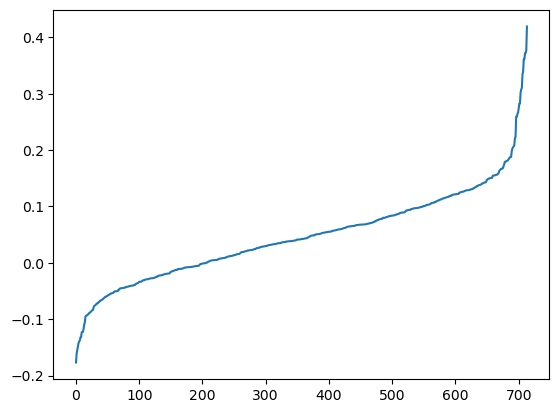

timestamp                  symbol
2022-09-23 22:00:00+00:00  ADA      -0.052983
                           ATOM     -0.056600
                           BTC       0.500000
                           DOT      -0.052685
                           ETC      -0.062342
                                       ...   
2022-11-22 22:00:00+00:00  ETH      -0.203751
                           LINK      0.123600
                           LTC       0.305816
                           MATIC     0.014836
                           XRP      -0.001755
Name: position, Length: 14410, dtype: float32
['ADA', 'ATOM', 'BTC', 'DOT', 'ETC', 'ETH', 'LINK', 'LTC', 'MATIC', 'XRP']
test shift predict


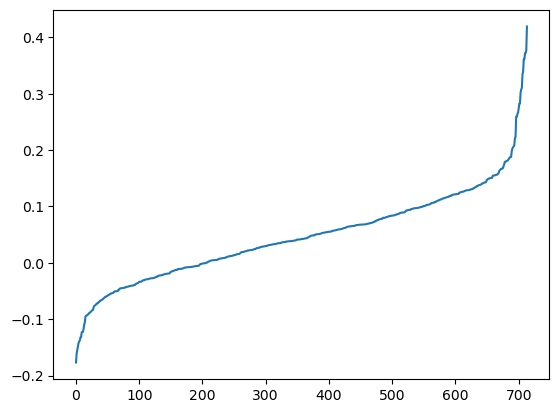

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


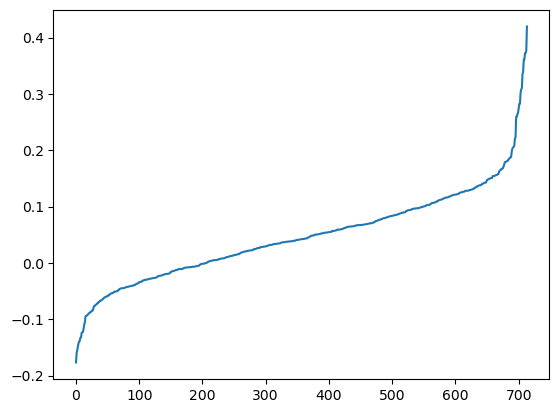

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


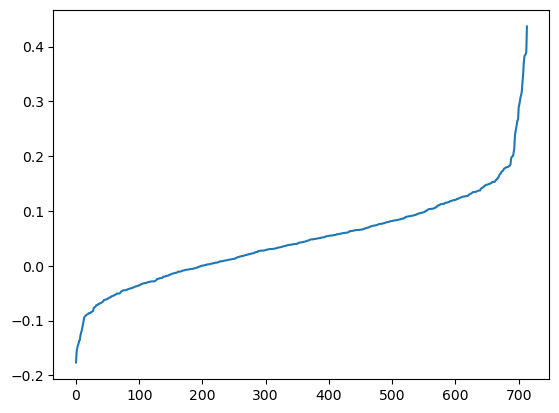

position1  position2  position3
timestamp                 symbol                                 
2022-09-23 23:00:00+00:00 ADA      0.052065   0.052065  -0.056963
                          ATOM     0.047317   0.047317  -0.055878
                          BTC     -0.500000  -0.500000   0.500000
                          DOT      0.051876   0.051876  -0.056583
                          ETC      0.066137   0.066137  -0.056245
...                                     ...        ...        ...
2022-11-22 21:00:00+00:00 ETH     -0.167443  -0.167443  -0.165991
                          LINK     0.158722   0.158722   0.157945
                          LTC      0.311442   0.311442   0.309918
                          MATIC    0.003195   0.003195   0.003180
                          XRP     -0.000426  -0.000426  -0.001949

[14390 rows x 3 columns]

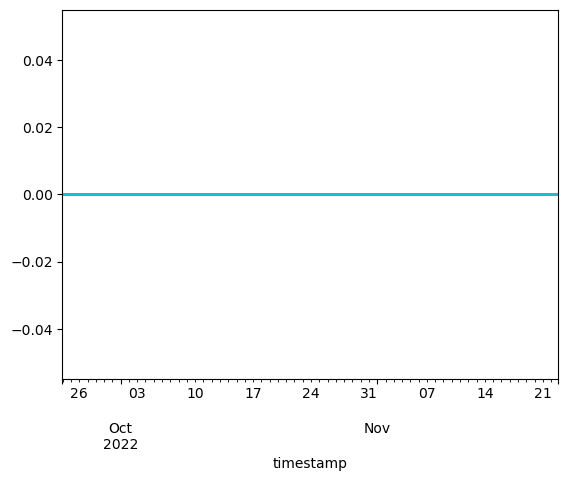

ADA (1439, 4)
ATOM (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETC (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
LTC (1439, 4)
MATIC (1439, 4)
XRP (1439, 4)


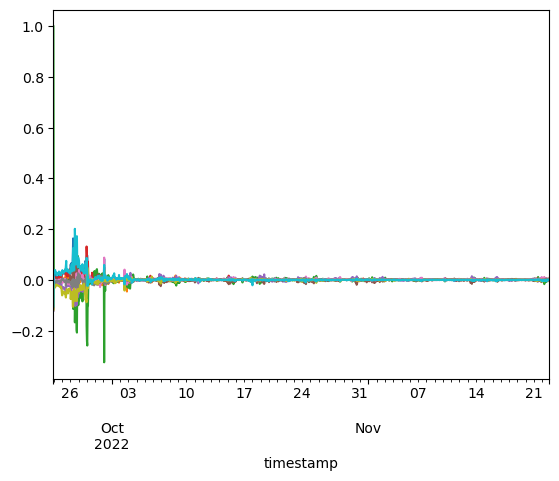

In [16]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/{}.xz'.format(model_name))
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

In [17]:
# https://arxiv.org/pdf/1902.06853.pdf

def eoc_v(f, sigma_w=1.0):
    def v(x):
        n = 10000
        z = np.random.normal(0, 1, n)
        return sigma_w ** 2 * np.mean(f(x ** 0.5 * z) ** 2)
    return v

def eoc_sigma_w(f, f_deriva, sigma_b=0.0):
    f_v = eoc_v(f)
    f_deriva_v = eoc_v(f_deriva)
    q = 0
    for i in range(100):
        q = sigma_b ** 2 + f_v(q) / f_deriva_v(q)
    return 1.0 / f_deriva_v(q) ** 0.5

# def gelu(x):
    
# def gelu_deriva(x):
    
    